In [1]:
%load_ext autoreload
%autoreload 2

---------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [4]:
from Util import to_log2_tpm
from Util import long_header

-------------

# Create Boxplots: **Gene Expression (GXP)** RNA

This mean we analyze the data for both **RNA-seq** related samples
- pA RNA **(Steady State RNA)**
- Pol II RIP **(Nascent RNA)**

This Notebook is used to generate the following **Box Plots**:
- **Figure-S2**:
    - WT & clr4Δ (Nascent RNA) - <del>**Figure-S2-A**</del>  <font color='red'> **Figure2-B** </font>
    - WT & clr4Δ (Steady State RNA) - <del>**Figure-S2-B**</del>  <font color='red'> **Figure2-D** </font>
- **Figure-S3**
    - Mutant group 1 (Nascent RNA) - <del>**Figure-S3-A**</del>  <font color='red'> **Figure-S6-A** </font>
    - Mutant group 2 (Nascent RNA) -  <del>**Figure-S3-B**</del>  <font color='red'> **Figure-S6-B** </font>
    - Mutant group 1 (Steady State RNA) - <del>**Figure-S3-C**</del>  <font color='red'> **Figure-S6-C** </font>
    - Mutant group 2 (Steady State RNA) - <del>**Figure-S3-D**</del>  <font color='red'> **Figure-S6-D** </font>


### <font color='blue'> **Attention!** In this Notebook we are not analyzing **ratios** but **absolute expression** </font>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [6]:
#from Viz import prepare_4cat_data, multi_4cat_box_plot ## use viz_strands instead!!
from viz_strands import prepare_4cat_data, multi_4cat_box_plot, my_multi_4cat_box_plot ## 4-category

-------------

- Define mutant grouping: **group 1**

In [7]:
samples1 = ['WT', '80', '638', '301', '324', '491', '302']

In [8]:
x_labels1 = ['wt', 'clr4Δ', 'ago1Δ', 'swi6Δ', 'chp2Δ', 'mit1Δ' ,'clr3Δ']

- Define mutant grouping: **group 2**

In [9]:
samples2 = ['WT', '504', '530', '510']

In [10]:
x_labels2 = ['wt', 'rrp6Δ', 'exo2Δ', 'caf1Δ']

- Define mutant grouping: **group 3**

In [11]:
samples3 = ['WT', '510', '544', '1022']

In [12]:
x_labels3 = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ']

- Define mutant grouping: **group 4**

In [13]:
samples4 = ['WT', '510', '544', '1022', '1168']

In [14]:
x_labels4 = ['wt', 'caf1Δ', 'ccr4Δ', 'mot2Δ', 'caf1*ccr4*']

-------------

## Import and prepare **Data**: Pol II RIP and pA RNA

-------------

- Import **RNA** merged **gene expression Matrix** per Mutant type: `rna_merged_tpm.csv`

In [15]:
#rna_file = '/data/parastou/RNAdeg/results/RipRna/xp_data/merged_tpm.csv'
rna_file = os.path.join(rna_dir, 'rna_merged_tpm.csv')
#rna_file = os.path.join(rna_dir, 'rna_merged_filtered_tpm.csv')
rna_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/RNA/rna_merged_tpm.csv'

In [16]:
df = pd.read_csv(rna_file, sep='\t')
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-RIP,1022_pA-RNA,1168_S2-RIP,1168_pA-RNA,...,638_S2-RIP,638_pA-RNA,638_total-RNA,80_S2-RIP,80_pA-RNA,80_total-RNA,WT_S2-RIP,WT_S5-RIP,WT_pA-RNA,WT_total-RNA
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,13.047263,8.610194,1.551187,0.812477,...,2.628246,2.906437,5.585458,2.941590,1.800442,3.257867,2.451086,0.000000,0.719070,1.761184
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,4.362461,5.435505,6.791771,1.182042,...,5.225105,10.515522,6.788815,4.632683,1.165227,0.000000,29.076151,55.013025,6.204396,0.000000
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,20.357270,57.937164,8.811443,83.772135,...,4.224988,6.463253,4.565533,18.242957,37.932886,26.830832,0.999979,0.000000,8.761472,25.896352
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
df.shape

(7021, 39)

- Get **sample columns** for filtering `NA`s properly:

In [18]:
sample_cols = [ss for ss in df.columns.tolist() if ss not in long_header]
len(sample_cols)
#sample_cols

33

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from zero counts: **fill with zeros** </font>
- <font color='red'> In `rna_merged_tpm.csv`, it should already have been taken care of! </font> 

In [19]:
# (NOT USED)
# => NAs originated from zero counts: fill with zeros
#df = df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#df = df.fillna({kk:0 for kk in sample_cols})

# (NOT USED) drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
#df = df.dropna(subset = sample_cols) 
#df = df.dropna(0)

In [20]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not df[sample_cols].isnull().values.any()

- **Log-transform** and filter for **Heterochromatic** and **Protein coding** (mRNA) genes

#### <font color='red'> **Attention!** Parastou used **log(x)** instead of **log(1+x)** </font>

In [21]:
# if using log(x) should remove zeros
df = df[~(np.isclose(df[sample_cols], 0.)).any(axis=1)]

# log transformed counts will be used to visualize boxplots
# => compute log(1+x) to avoid issues with zero counts
#df = to_log2_tpm(df, shift=0)
#df = to_log2_tpm(df, gene_id_col='gene_id') # default shift=1
df = to_log2_tpm(df, gene_id_col='gene_id', shift=0) # parastou used this, default shift=1

# Keep only protein coding genes
df = df[(df['category'] == 'repeat') | (df['category'] == 'gene')]
#df = df[(df['bio_type'] == 'mRNA') | (df['category'] == 'repeat')]
df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-RIP,1022_pA-RNA,1168_S2-RIP,1168_pA-RNA,...,638_S2-RIP,638_pA-RNA,638_total-RNA,80_S2-RIP,80_pA-RNA,80_total-RNA,WT_S2-RIP,WT_S5-RIP,WT_pA-RNA,WT_total-RNA
10,FP565355_region_9170..13408,NaN,4239,region,repeat,region,6.278013,2.515487,5.832927,0.339240,...,7.251393,6.654082,6.073542,8.435348,7.079729,5.803259,4.023291,5.370248,0.598139,4.044447
11,SPAC1002.01,mrx11,669,gene,gene,mRNA,4.728445,4.107719,2.721283,4.812252,...,4.911332,3.449770,3.037503,4.712046,3.629583,3.584534,4.252296,6.143346,4.042666,4.417504
12,SPAC1002.02,pom34,993,gene,gene,mRNA,5.899564,6.753219,6.192655,6.981798,...,6.000700,5.780021,5.333030,5.646739,5.842221,5.002921,6.028134,7.575247,6.585503,6.052893
13,SPAC1002.03c,gls2,3227,gene,gene,mRNA,6.558799,6.757096,6.713185,7.032427,...,6.320352,6.830600,6.128371,6.412229,6.811978,6.041107,6.597382,7.208778,6.777360,6.282141
14,SPAC1002.04c,taf11,868,gene,gene,mRNA,6.218668,6.565321,6.541554,7.214775,...,5.850349,6.292549,4.970313,5.982683,6.246231,4.538964,6.392269,7.416745,6.312550,4.922678


In [22]:
df.shape

(5965, 39)

In [23]:
#df[df['gene_id'].isin(non_degraded)]

----

# **I.** Create Boxplots: **pA RNA** (Steady State RNA)

----

- Define `seq_assay` for  **pA RNA** (Steady State RNA)

In [24]:
seq_assay = "pA-RNA"

In [25]:
#df[df['gene_id'].isin(deg1)][[i + '_pA-RNA' for i in ['WT', '80']]]

### WT & clr4Δ - <del>**Figure-S2-B**</del>  <font color='red'> **Figure2-D** </font>

- **Supplemental Figure S2**:  
    - **(B)** pA RNA-seq results (steady state RNA) shown as box plot for wild type and clr4Δ cells. Average of at least two independent samples is shown. 

In [26]:
#fig_dir = os.path.join(plots_dir, 'Figure-S2')
fig_dir = os.path.join(plots_dir, 'Figure2')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure2/Figure2-D.png


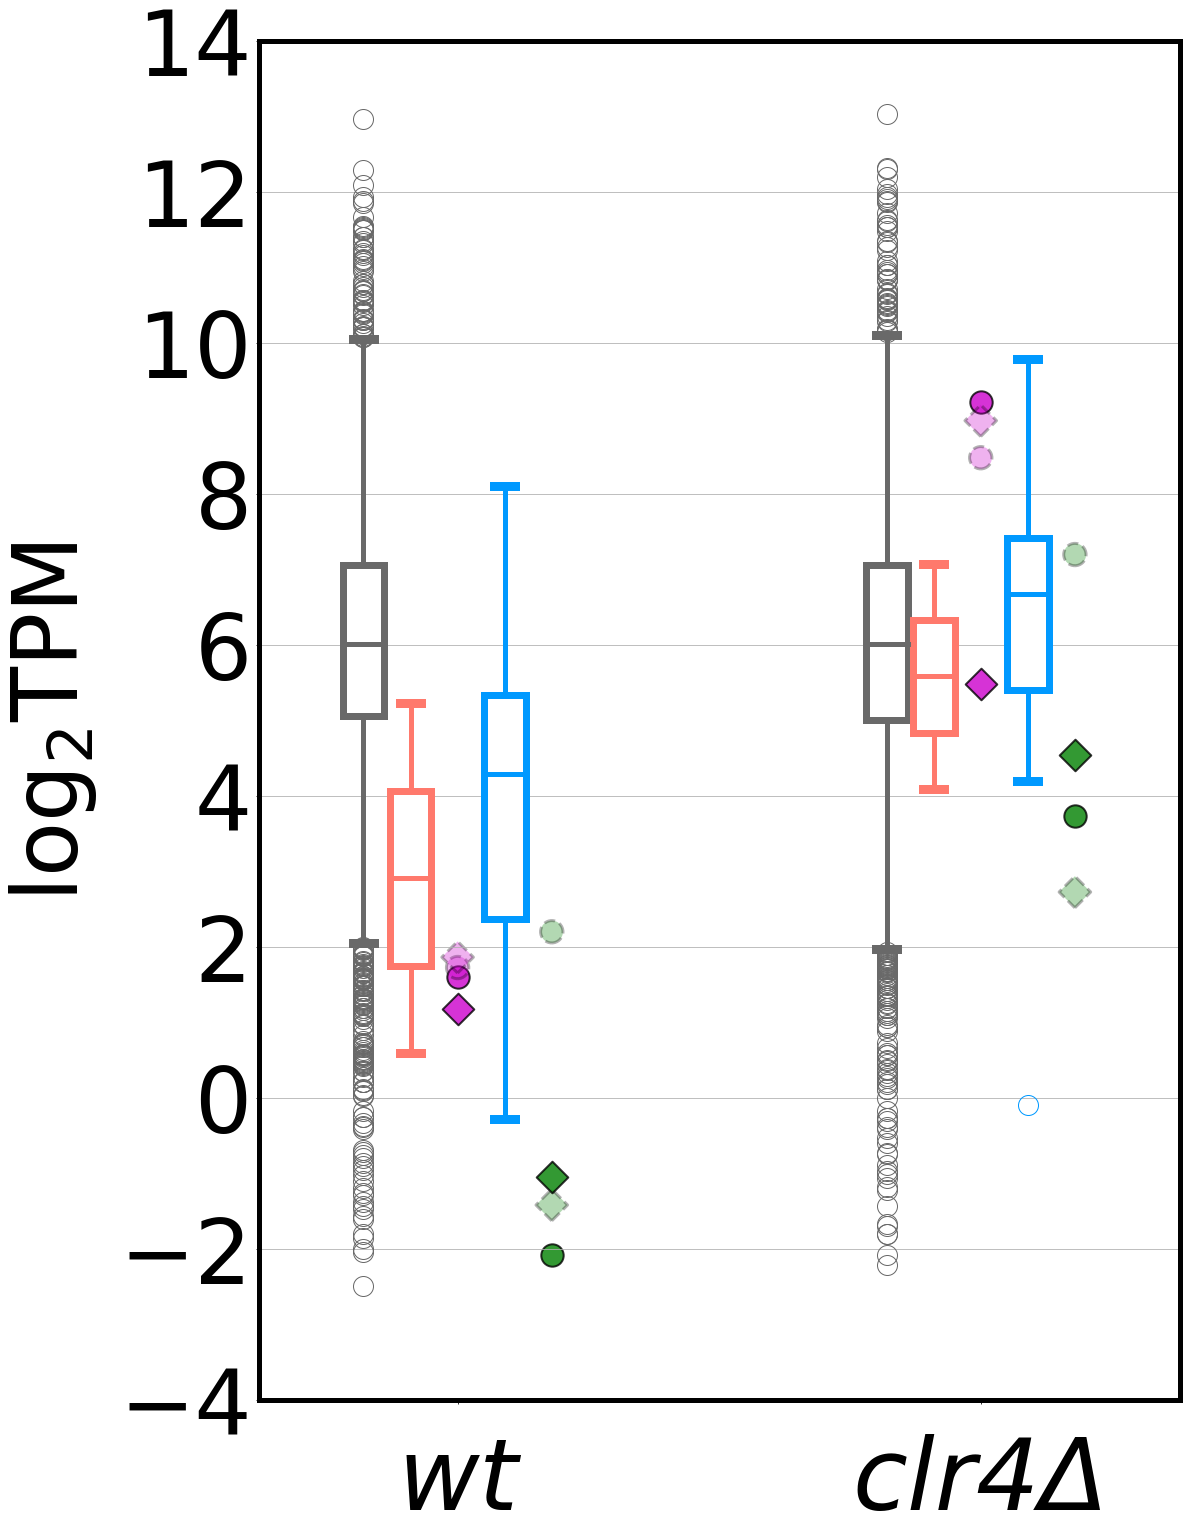

In [27]:
# data and labels
#samples = [i + '_pA-RNA' for i in ['WT', '80']]
samples = [i + '_' + seq_assay for i in ['WT', '80']]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S2-B.png')
#out_path = os.path.join(fig_dir, 'Figure-S2-B.png')
out_path = os.path.join(fig_dir, 'Figure2-D.png')
print(out_path)

#multi_4cat_box_plot(df, samples,
my_multi_4cat_box_plot(
    df, samples, 
    ['wt', 'clr4Δ'], 
    out_path,
    figsize=(16.5, 25),
    dist=5, 
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14),
    widths=.8,
    xlable_size=100, ylable_size=90,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis,
)

----

## Mutant group 1 - <del>**Figure-S3-C**</del>  <font color='red'> **Figure-S6-C** </font>

- **Supplemental Figure S3**:  
    - **(C + D)** pA RNA-seq results (steady state RNA) shown as box plot for individual mutants affecting
    - **(C)** heterochromatin formation. Average of at least two independent samples is shown.

In [28]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-C.png


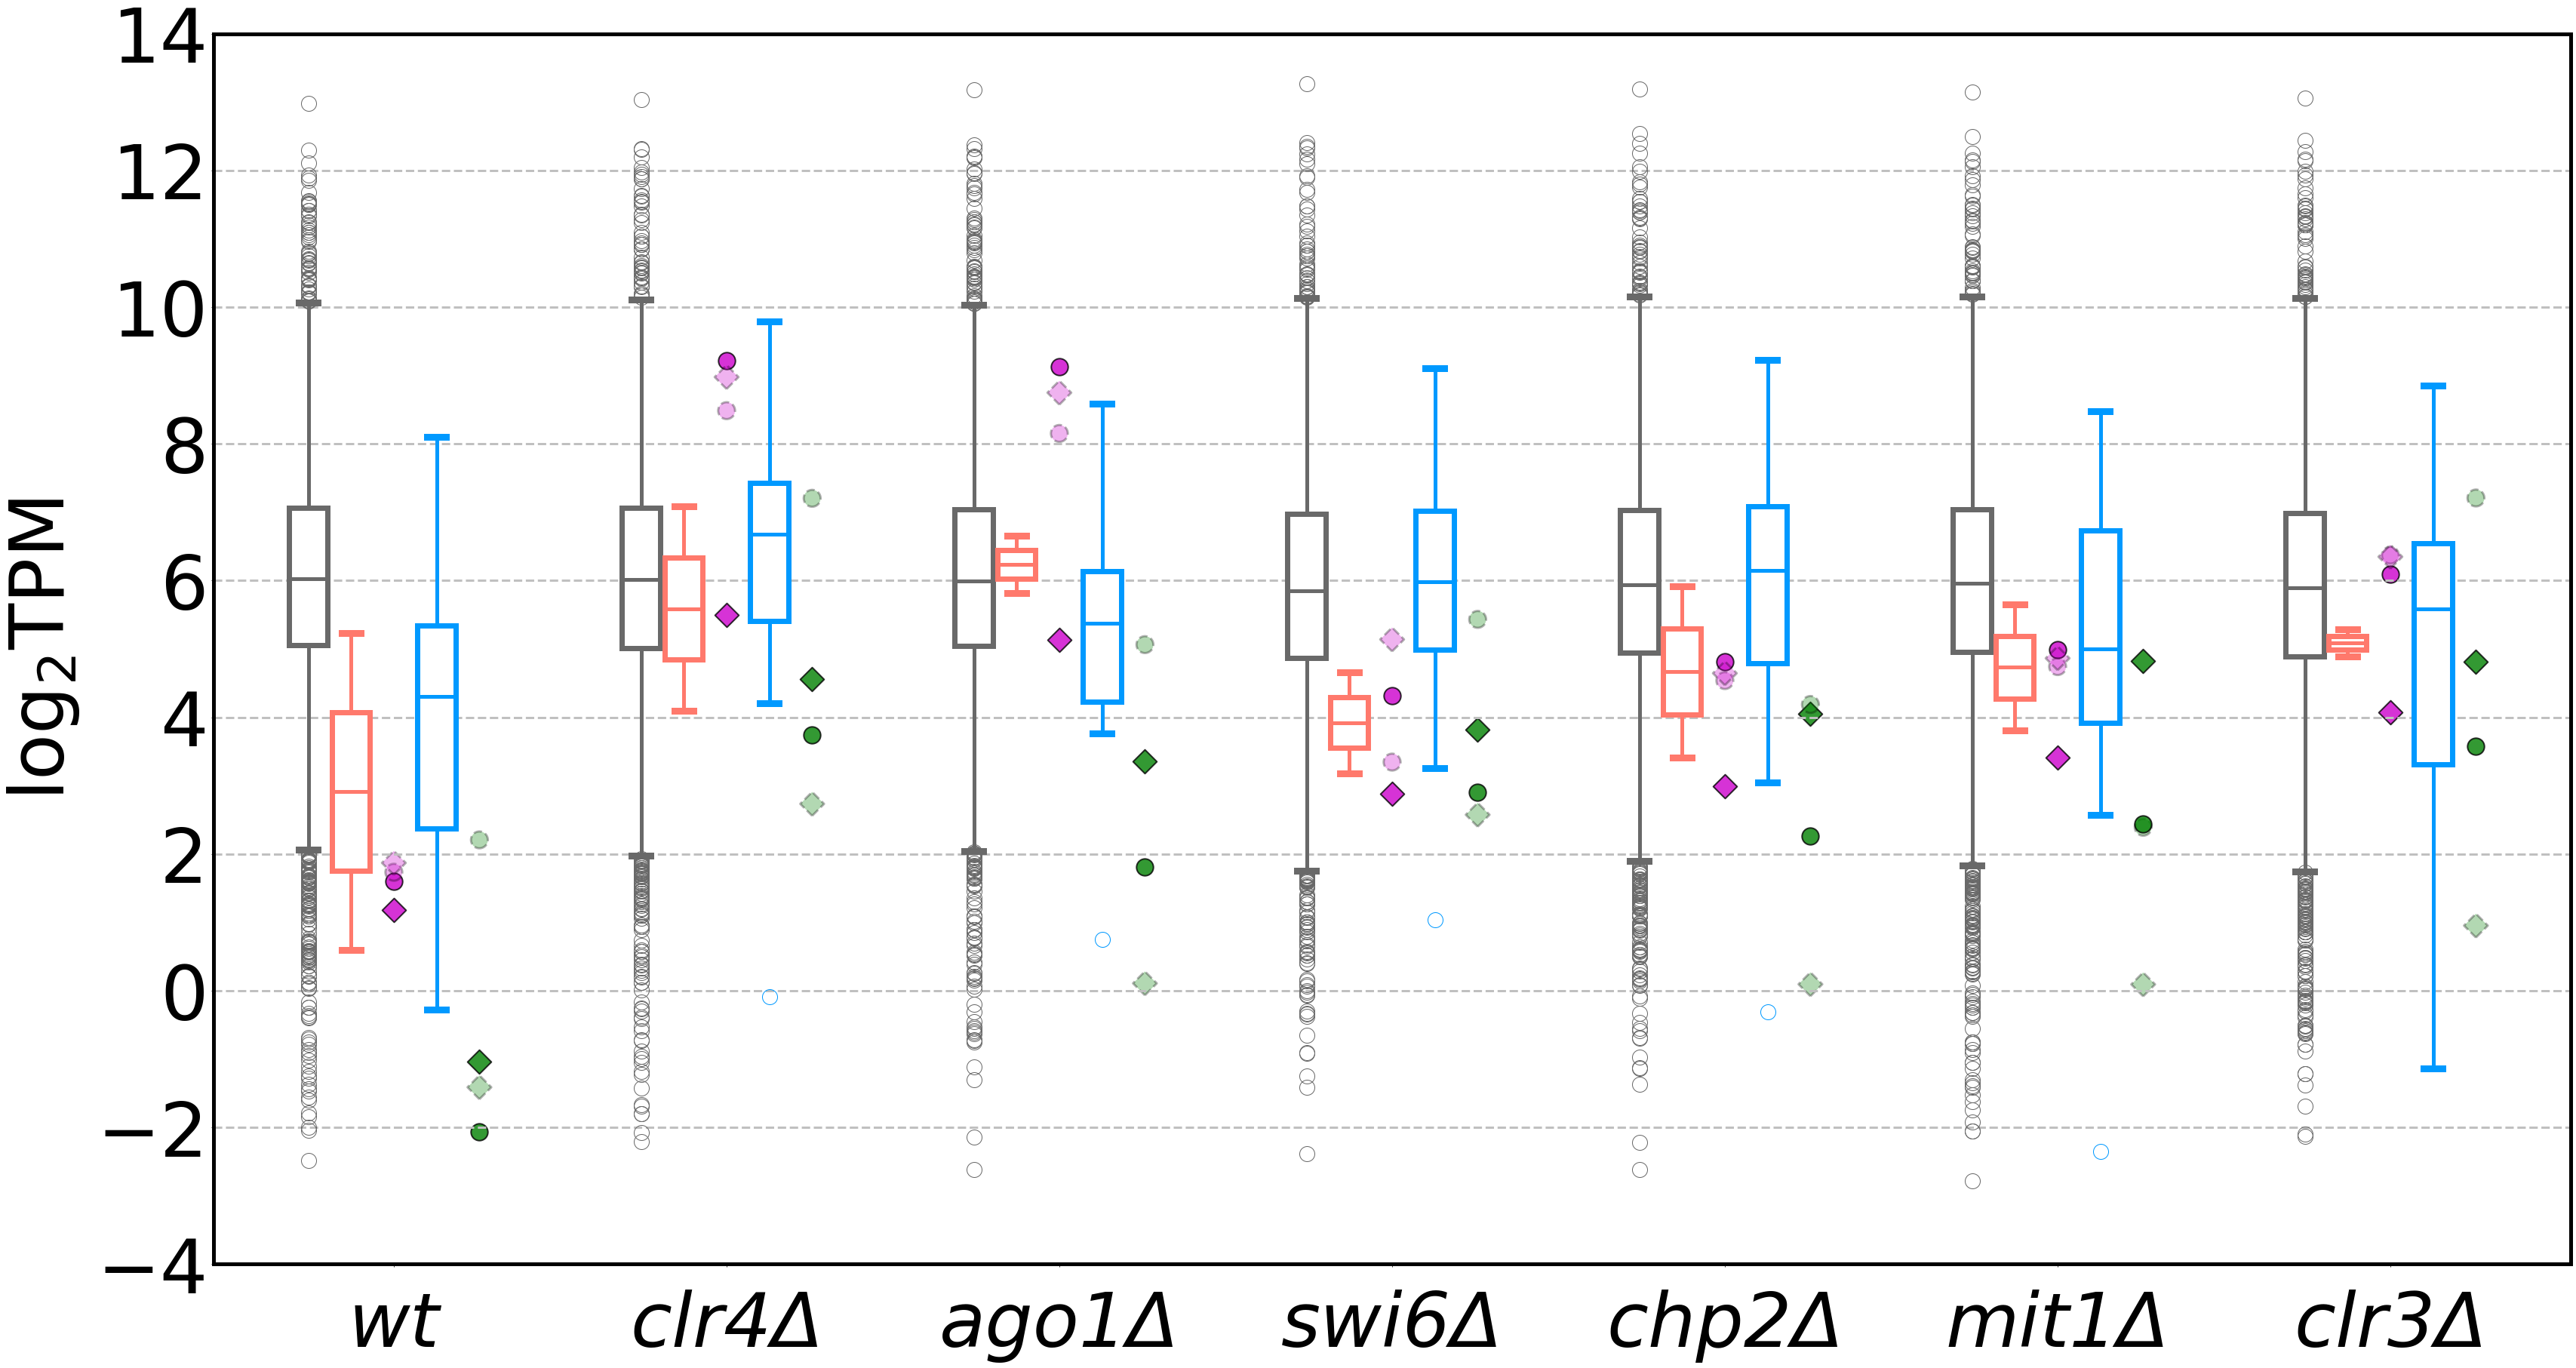

In [29]:
# data and labels
#samples = [i + '_pA-RNA' for i in samples1]
samples = [i + '_' + seq_assay for i in samples1]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-C.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-C.png')
out_path = os.path.join(fig_dir, 'Figure-S6-C.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    x_labels1,
    out_path, 
    figsize=(56, 30), 
    dist=6, 
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14), 
    widths=.8, 
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 2 - <del>**Figure-S2-D**</del>  <font color='red'> **Figure-S6-D** </font>

- **Supplemental Figure S3**:  
    - **(C + D)** pA RNA-seq results (steady state RNA) shown as box plot for individual mutants affecting
    - **(D)** RNA degradation. Average of at least two independent samples is shown.

In [30]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-D.png


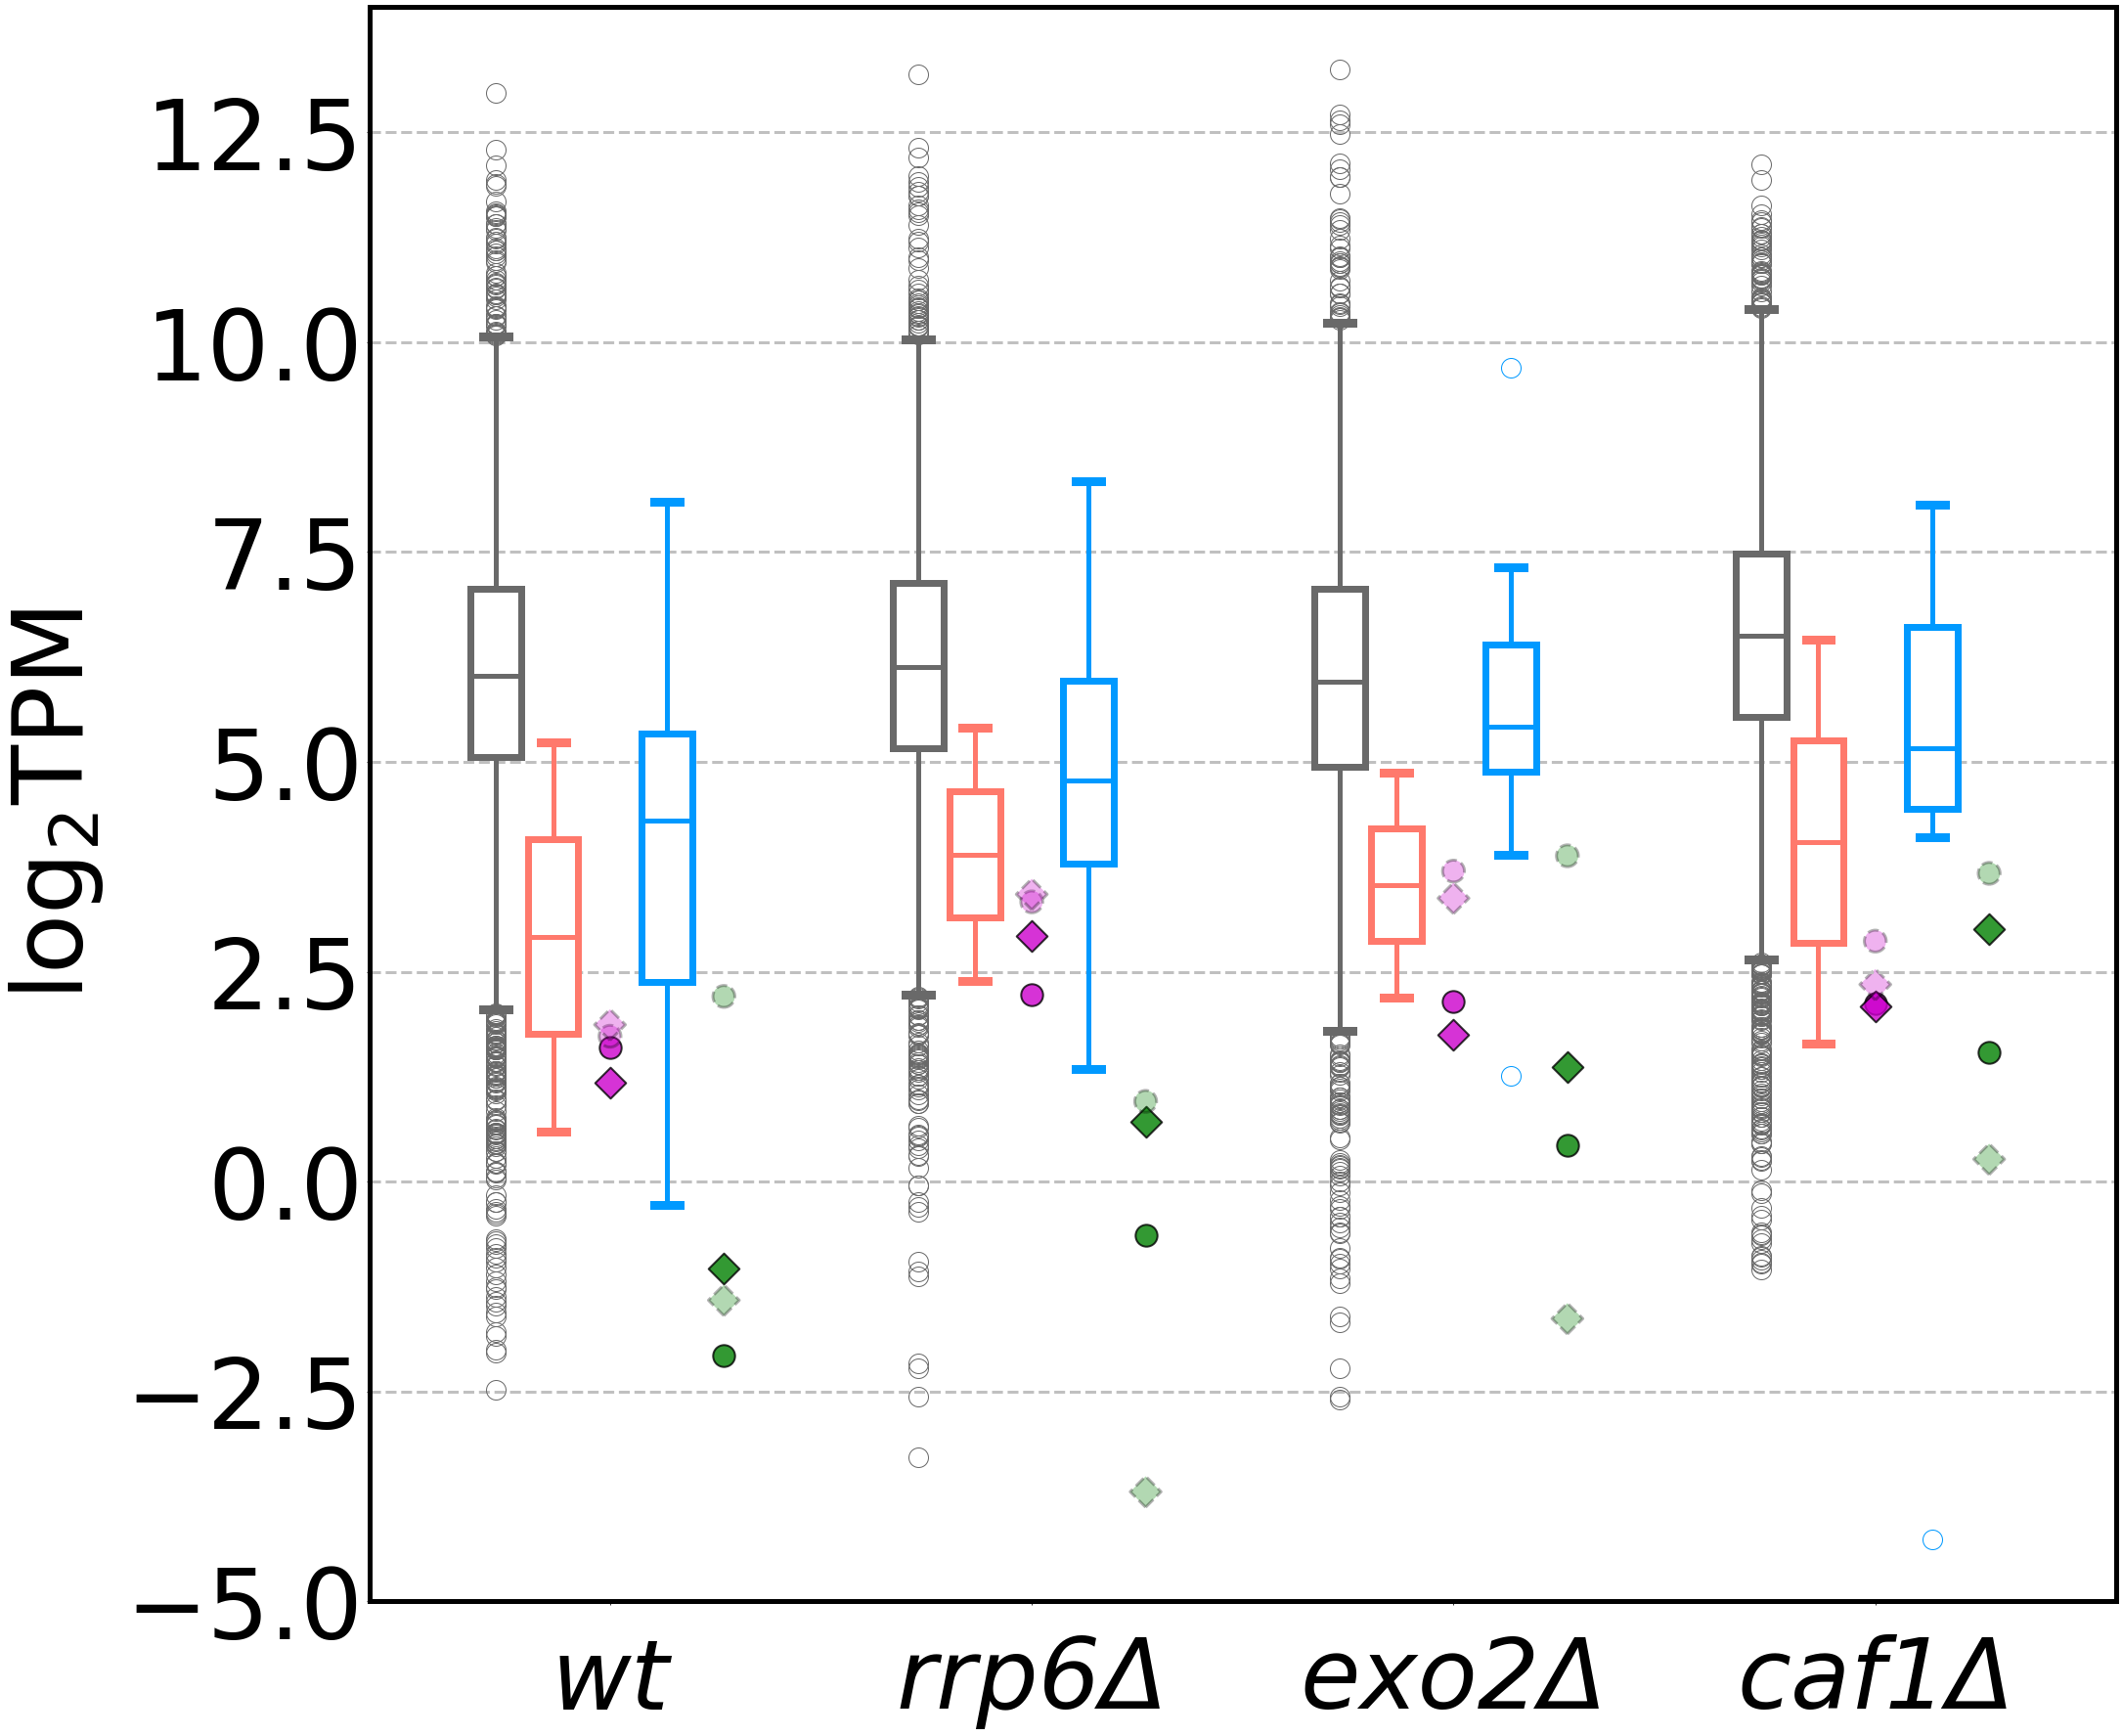

In [31]:
# data and labels
#samples = [i + '_pA-RNA' for i in samples2]
samples = [i + '_' + seq_assay for i in samples2]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-D.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-D.png')
out_path = os.path.join(fig_dir, 'Figure-S6-D.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    x_labels2,
    out_path, 
    figsize=(32, 30), 
    dist=5,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-5, 14),  
    widths=.8, 
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 3 - <del>**Figure-S3-D-extra-ccr4-not-1**</del>  <font color='red'> **Figure-S6-D-extra-ccr4-not-1** </font>

- **Supplemental Figure S3**:  
    - **(C + D)** pA RNA-seq results (steady state RNA) shown as box plot for individual mutants affecting
    - **(D)** RNA degradation. Average of at least two independent samples is shown.

In [32]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-D-extra-ccr4-not-2.png


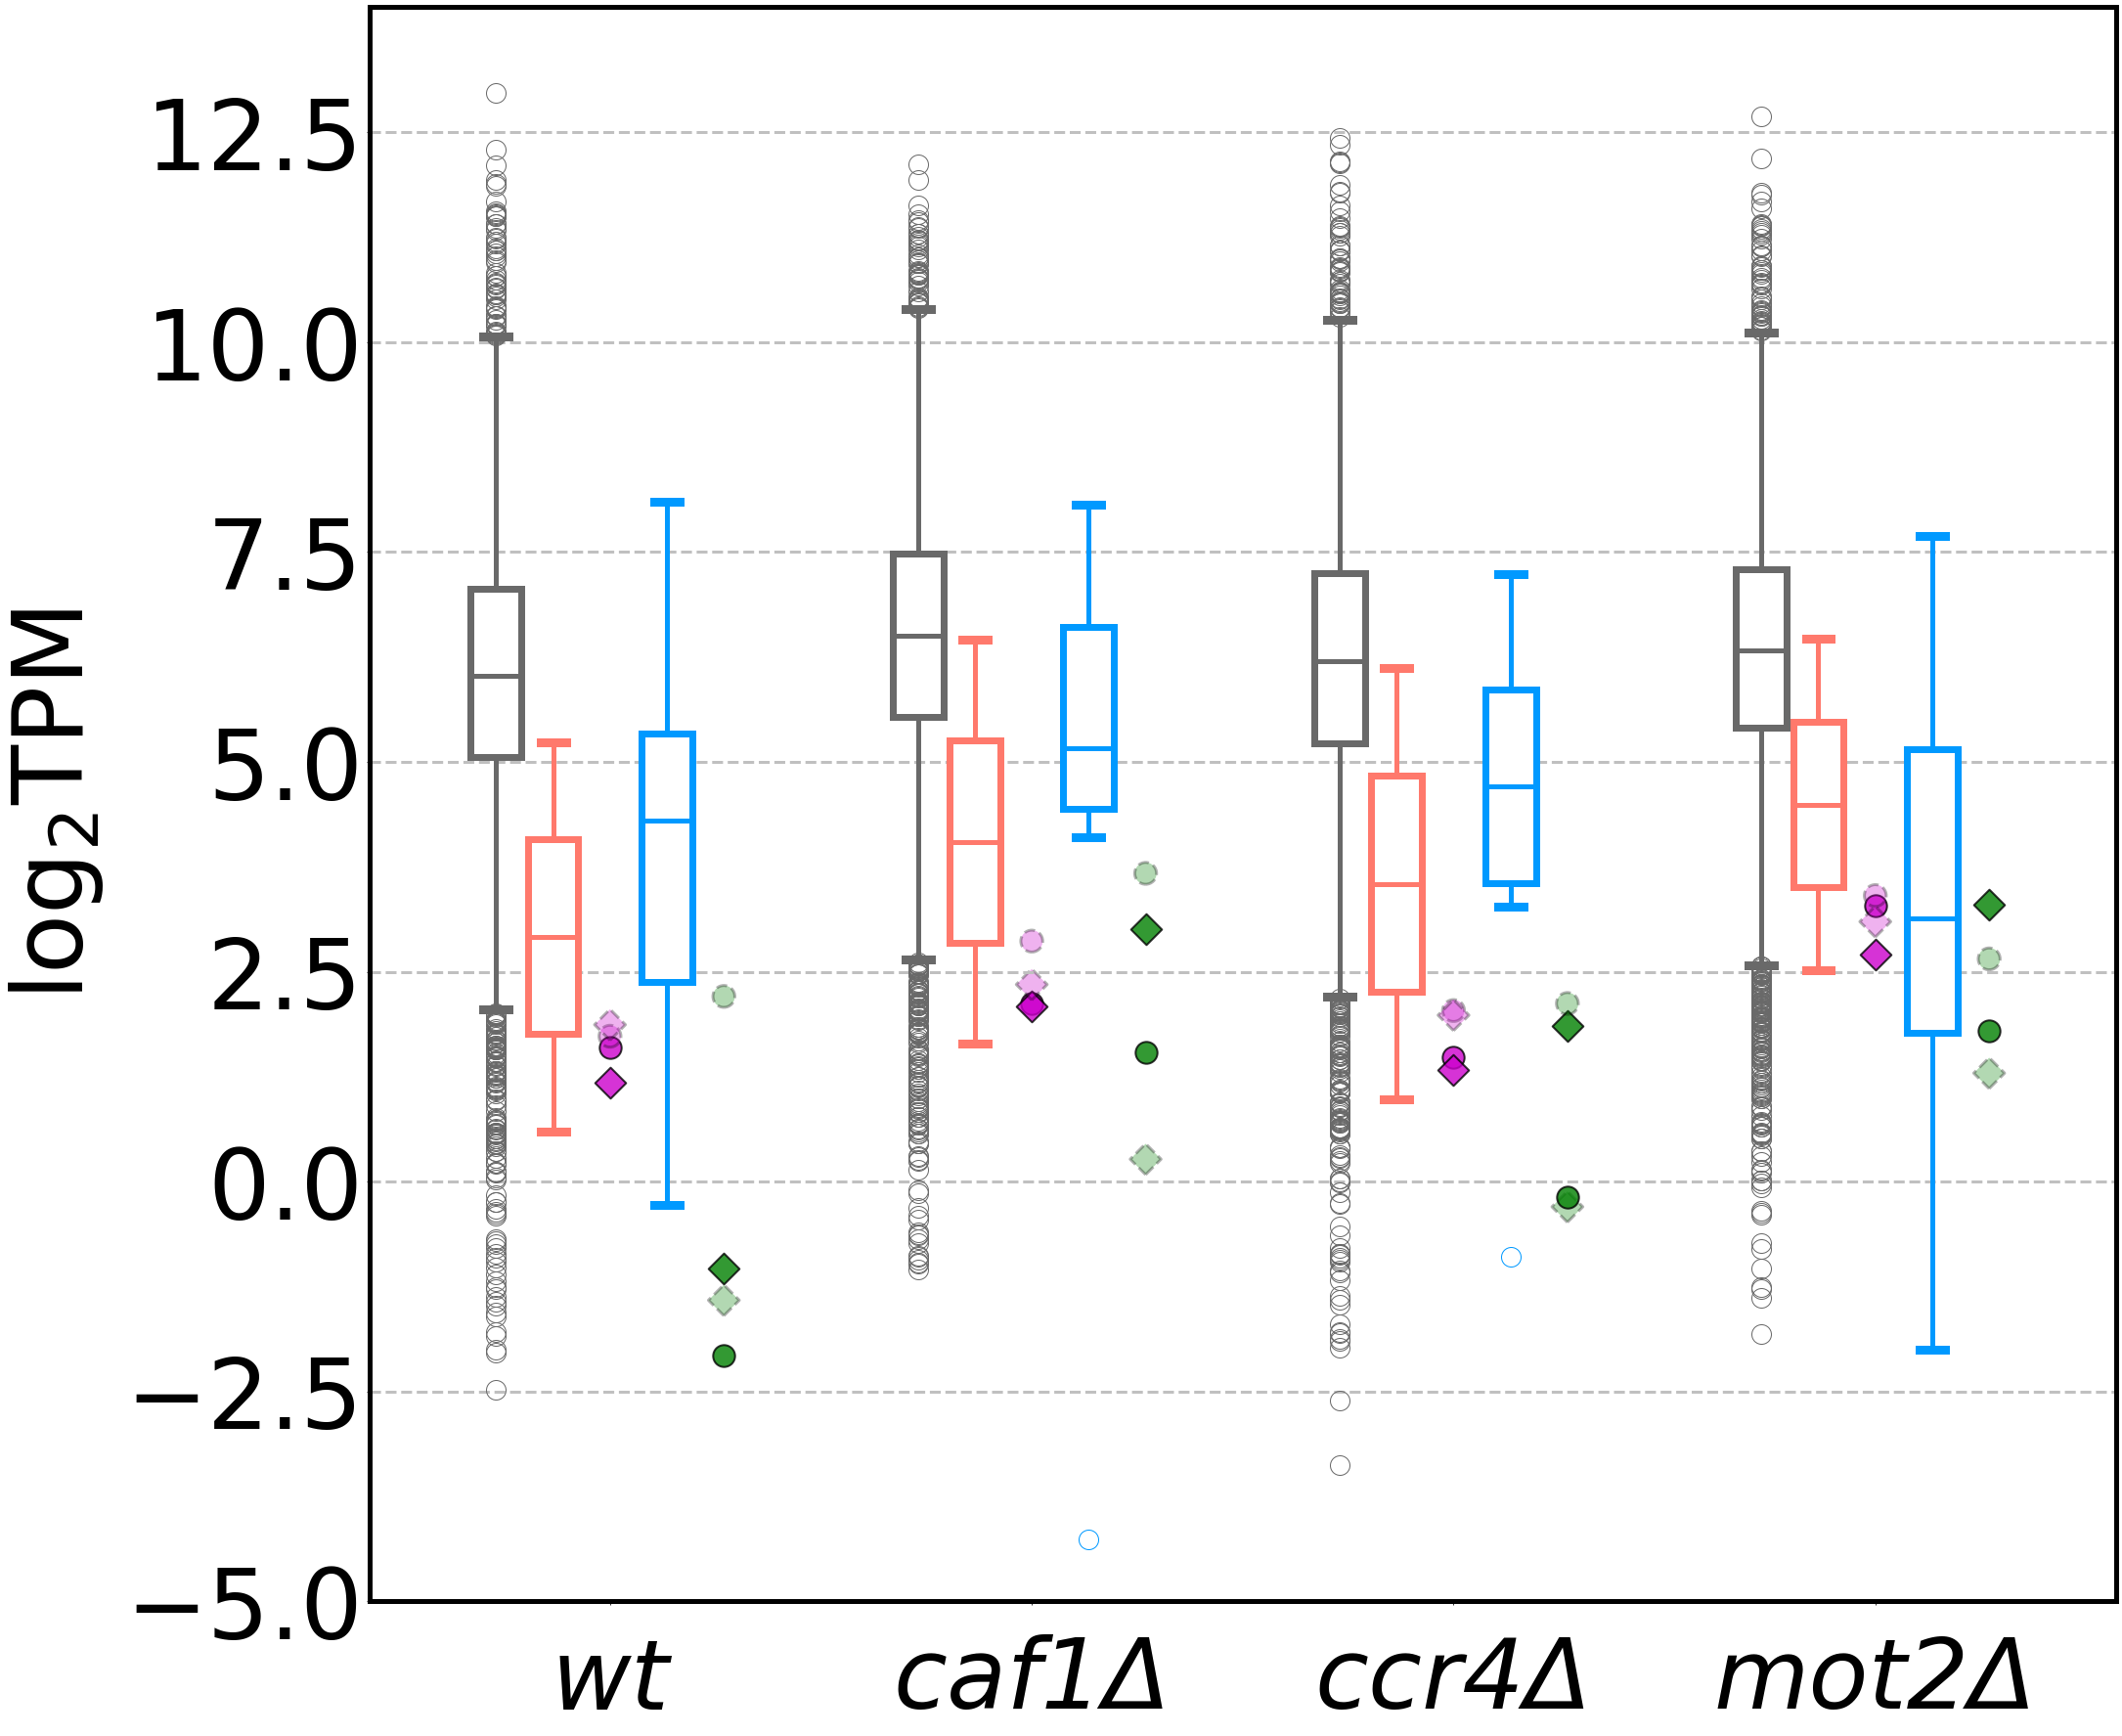

In [33]:
# data and labels
#samples = [i + '_pA-RNA' for i in samples3]
samples = [i + '_' + seq_assay for i in samples3]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-D-extra-ccr4-not-1.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-D-extra-ccr4-not-1.png')
out_path = os.path.join(fig_dir, 'Figure-S6-D-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    x_labels3,
    out_path, 
    figsize=(32, 30), 
    dist=5,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-5, 14),  
    widths=.8, 
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 4 - <del>**Figure-S3-D-extra-ccr4-not-2**</del>  <font color='red'> **Figure-S6-D-extra-ccr4-not-2** </font>

- **Supplemental Figure S3**:  
    - **(C + D)** pA RNA-seq results (steady state RNA) shown as box plot for individual mutants affecting
    - **(D)** RNA degradation. Average of at least two independent samples is shown.

In [34]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-D-extra-ccr4-not-2.png


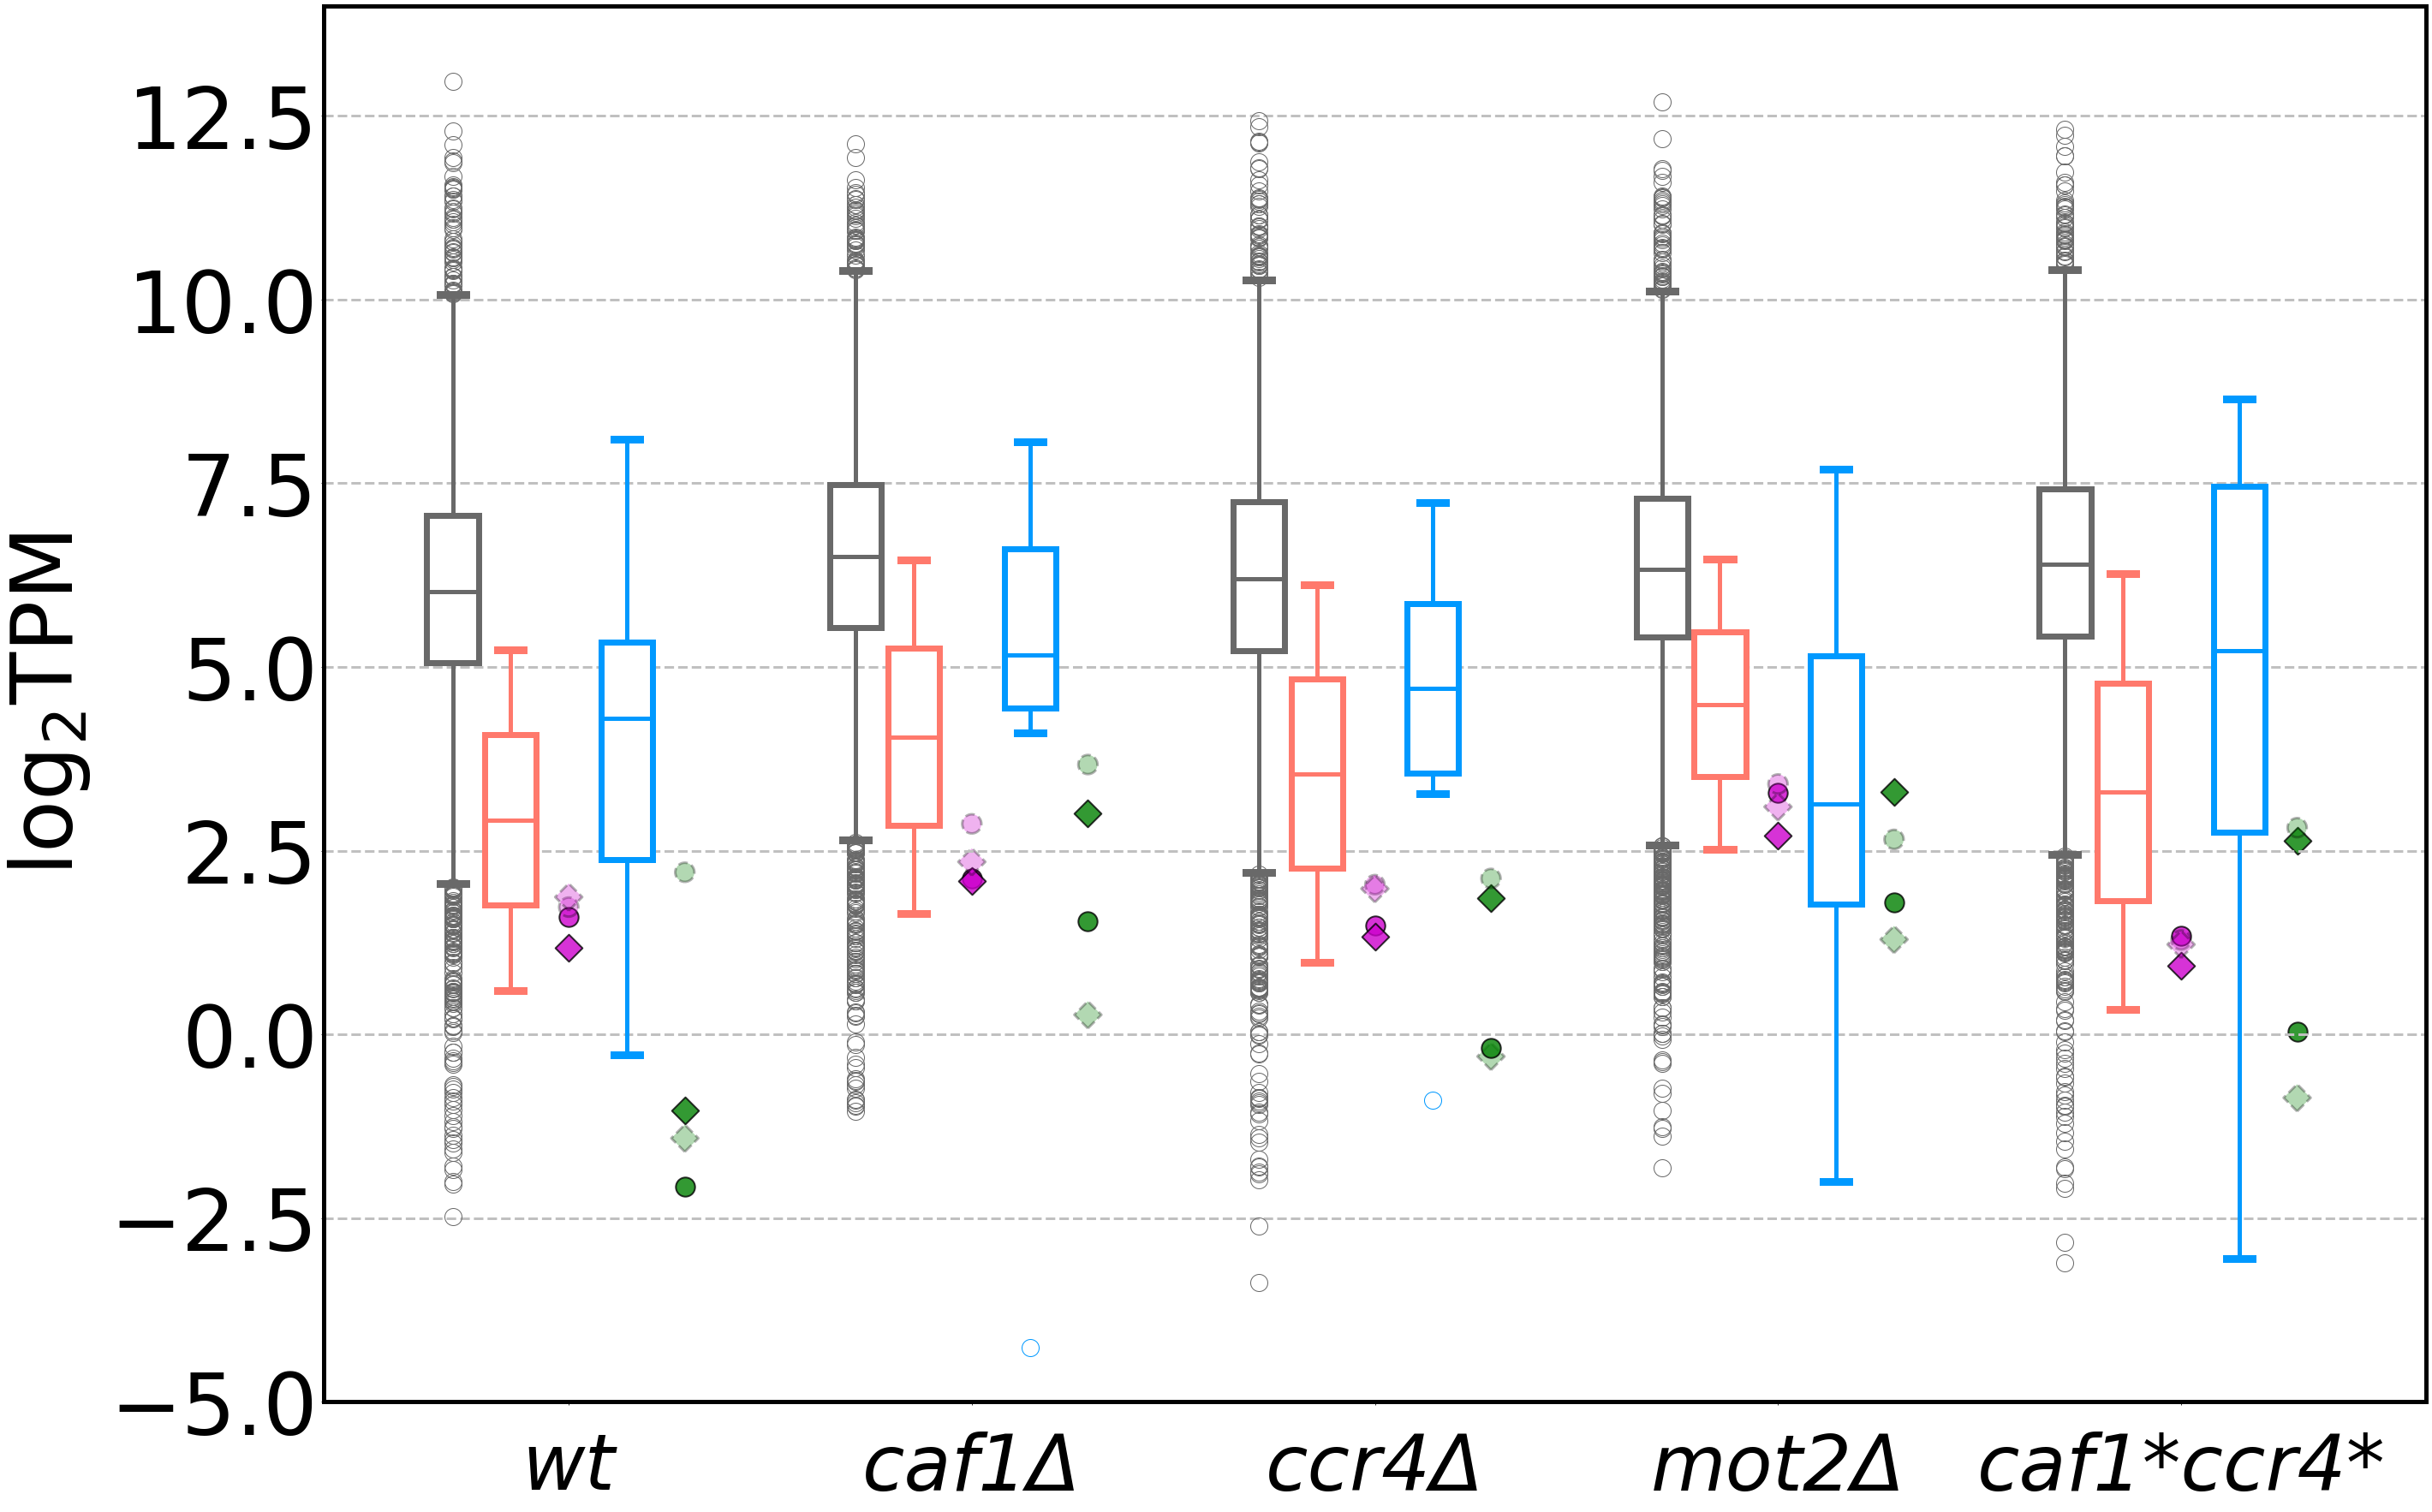

In [35]:
# data and labels
#samples = [i + '_pA-RNA' for i in samples4]
samples = [i + '_' + seq_assay for i in samples4]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-D-extra-ccr4-not-2.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-D-extra-ccr4-not-2.png')
out_path = os.path.join(fig_dir, 'Figure-S6-D-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    x_labels4,
    out_path, 
    figsize=(44, 30), 
    dist=5,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-5, 14),  
    widths=.8, 
    xlable_size=90, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

# II. Create Boxplots: **Pol II RIP** (Nascent RNA)

----

- Define `seq_assay` for **Pol II RIP** (Nascent RNA)

In [36]:
seq_assay = "S2-RIP"

### WT & clr4Δ - <del>**Figure-S2-A**</del>  <font color='red'> **Figure2-B** </font>

- **Supplemental Figure S2**:  
    - **(A)** Box plot showing S2P-Pol II RIP-seq data (nascent RNA). Nascent RNA analysis is shown for wild type and clr4Δ cells. Average of at least two independent samples is shown. 

In [37]:
#fig_dir = os.path.join(plots_dir, 'Figure-S2')
fig_dir = os.path.join(plots_dir, 'Figure2')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure2/Figure2-B.png


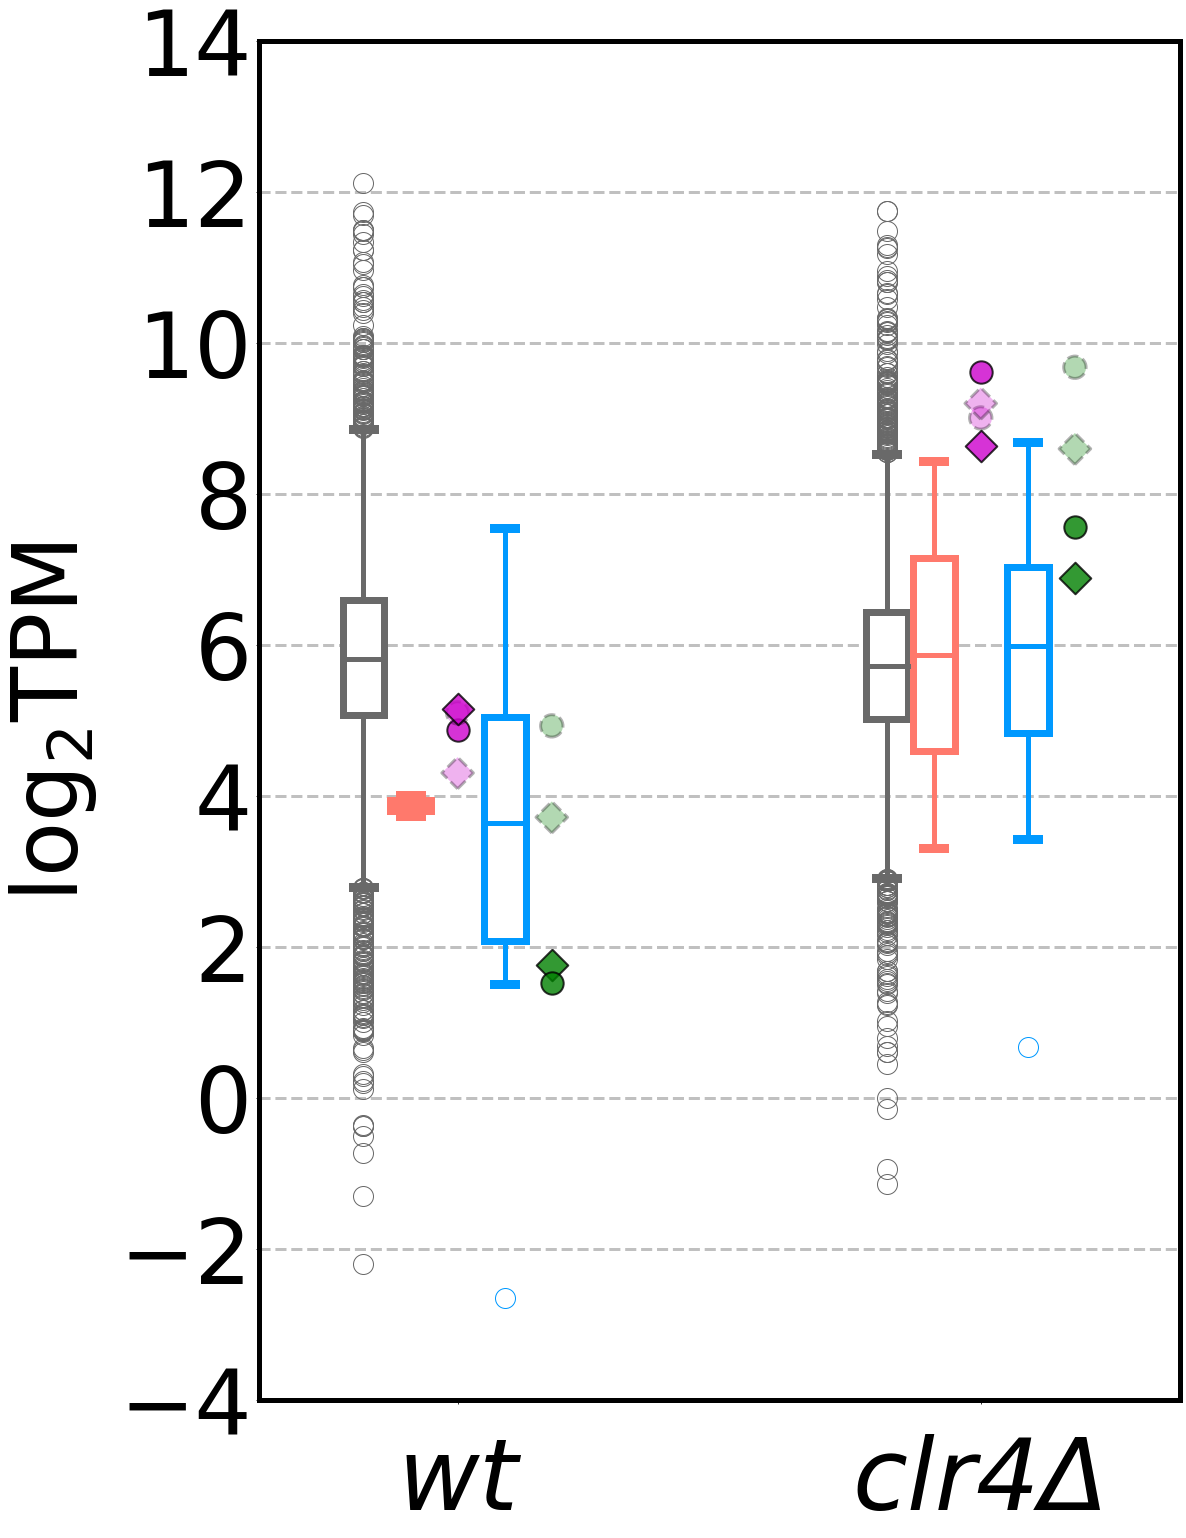

In [38]:
# data and labels
#samples = [i + '_S2-RIP' for i in ['WT', '80']]
samples = [i + '_' + seq_assay for i in ['WT', '80']]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S2-A.png')
#out_path = os.path.join(fig_dir, 'Figure-S2-A.png')
out_path = os.path.join(fig_dir, 'Figure2-B.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples, 
    ['wt', 'clr4Δ'],
    out_path, 
    figsize=(16.5, 25),
    dist=5,
    widths=.8,
    y_label='$\mathrm{log_2TPM}$', 
    y_lim=(-4, 14),
    xlable_size=100, ylable_size=90,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 1 - <del>**Figure-S3-A**</del>  <font color='red'> **Figure-S6-A** </font>

- **Supplemental Figure S3**:  
    - **(A + B)** Box plot showing S2-Pol II RIP-seq data. Nascent RNA analysis is shown for individual mutants affecting 
    - **(A)** heterochromatin formation. Average of at least two independent samples is shown

In [39]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-A.png


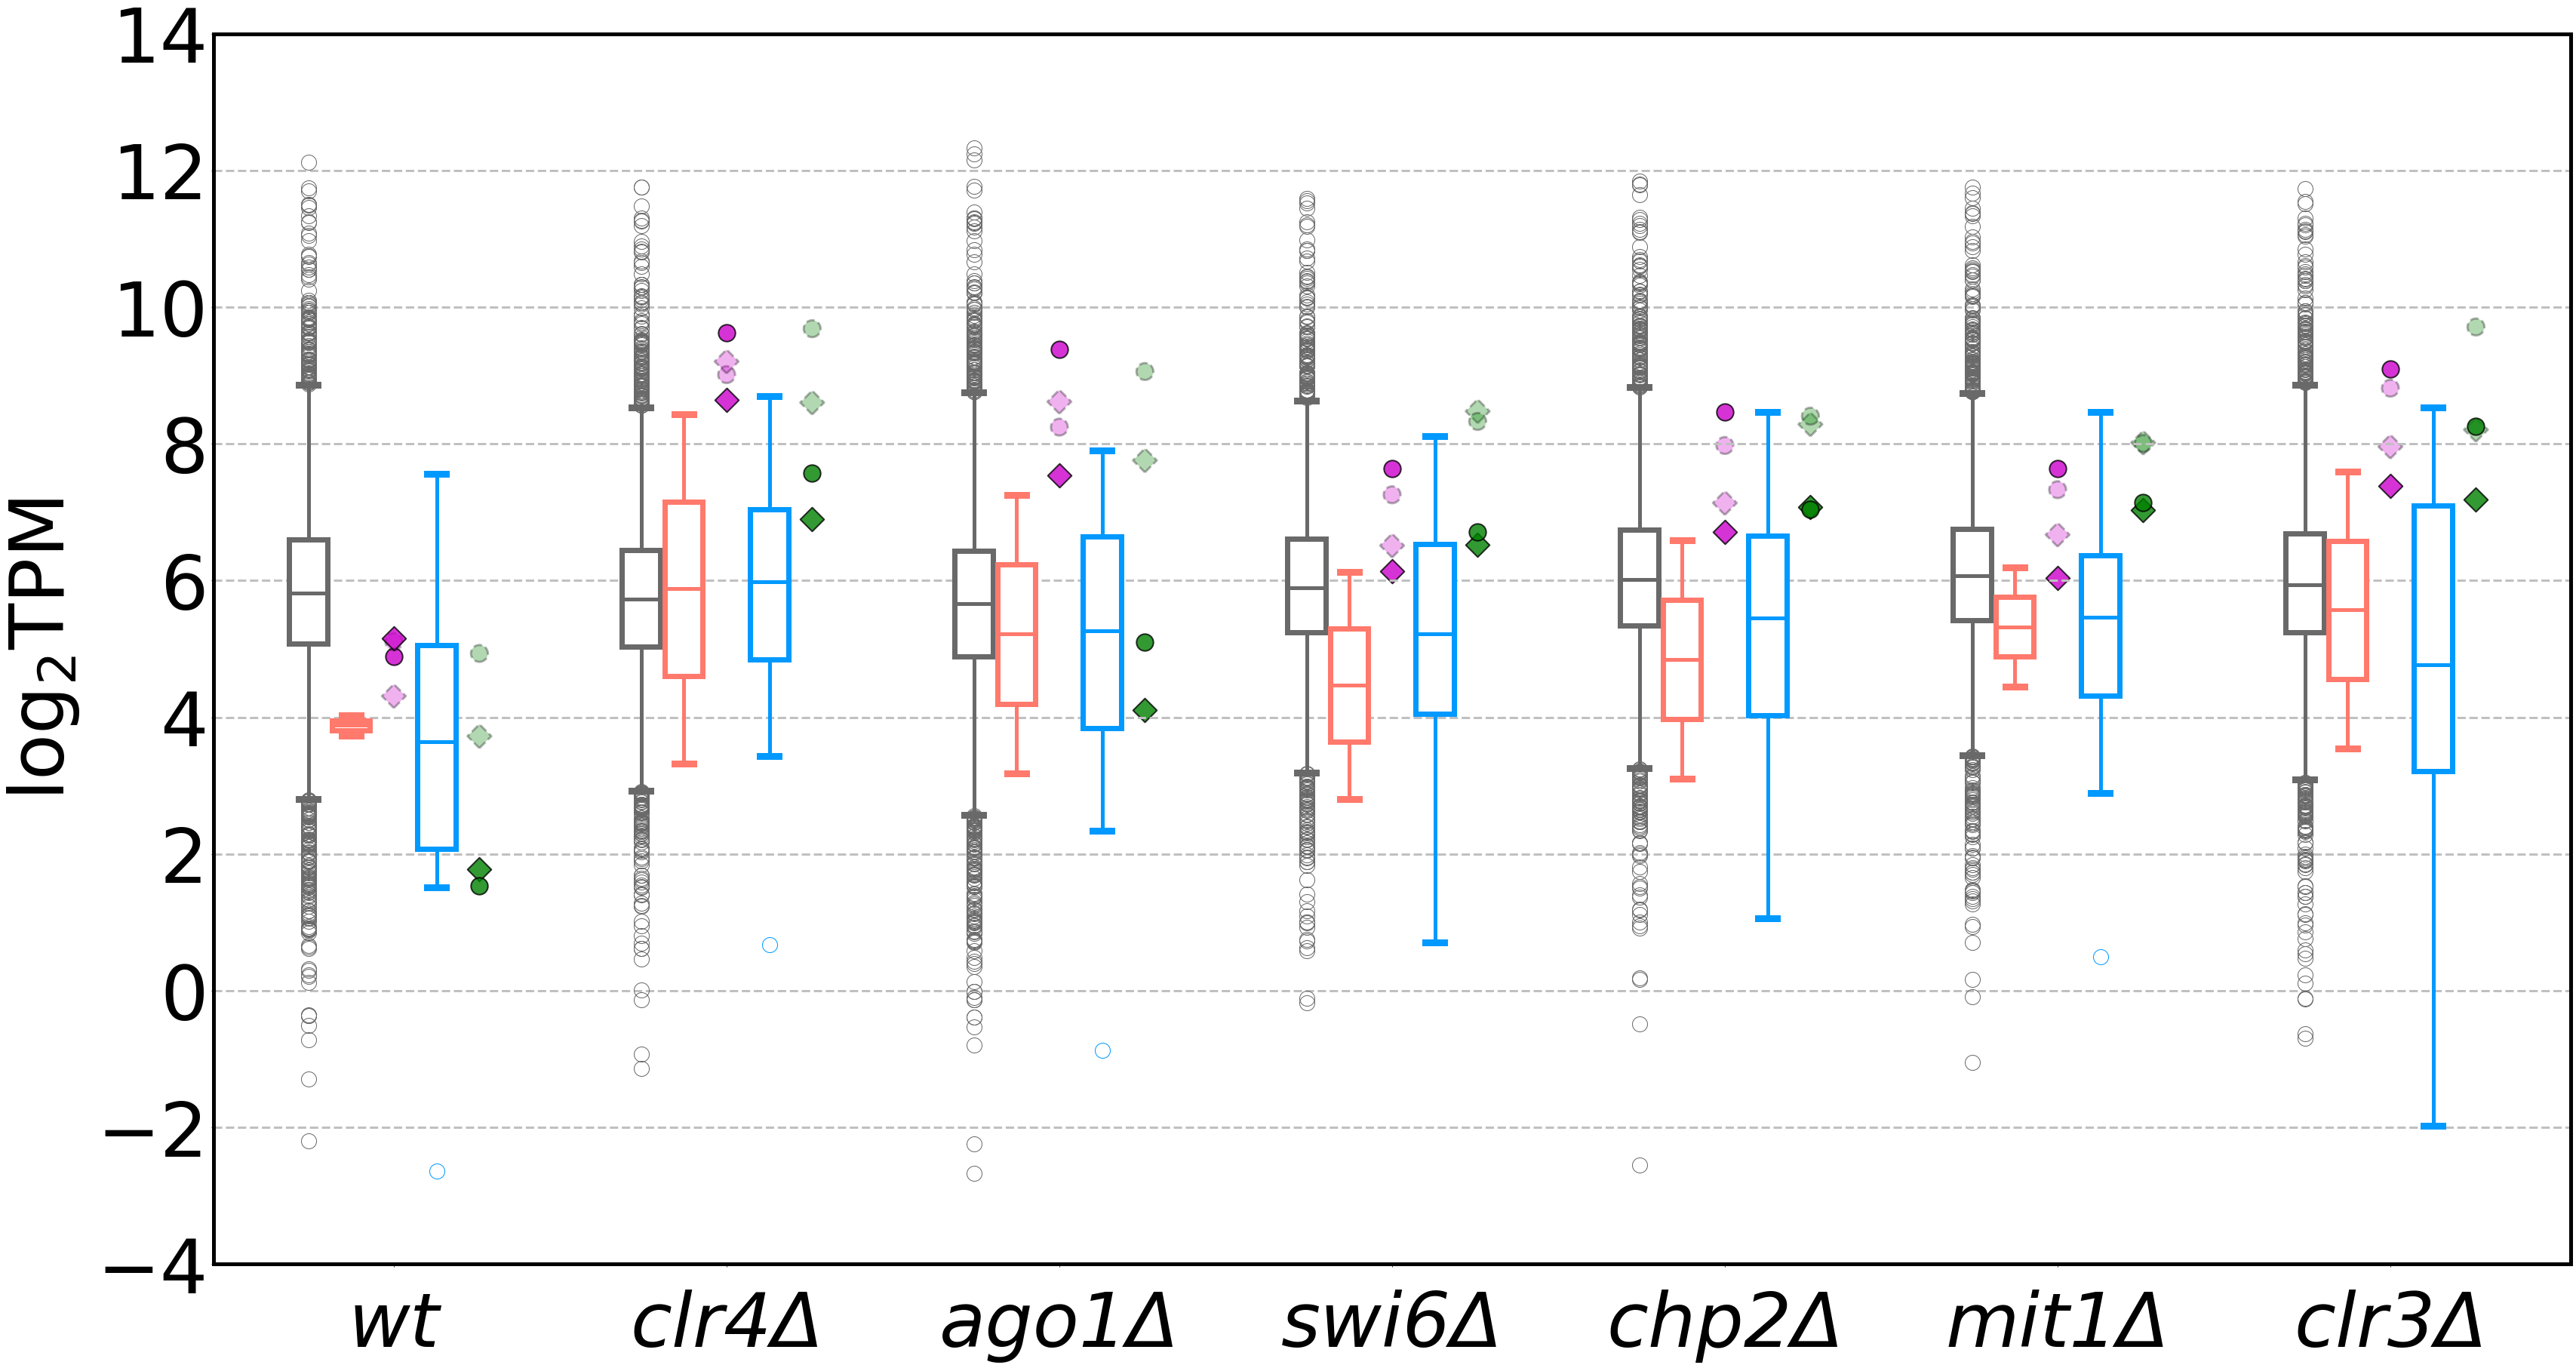

In [40]:
# data and labels
#samples = [i + '_S2-RIP' for i in samples1]
samples = [i + '_' + seq_assay for i in samples1]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-A.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-A.png')
out_path = os.path.join(fig_dir, 'Figure-S6-A.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                 
    x_labels1, 
    out_path,
    figsize=(56, 30),
    dist=6, 
    widths=.8,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14),
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

----

## Mutant group 2 - <del>**Figure-S3-B**</del>  <font color='red'> **Figure-S6-B** </font>

- **Supplemental Figure S3**:  
    - **(A + B)** Box plot showing S2-Pol II RIP-seq data. Nascent RNA analysis is shown for individual mutants affecting 
    - **(B)** RNA degradation. Average of at least two independent samples is shown

In [41]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-B.png


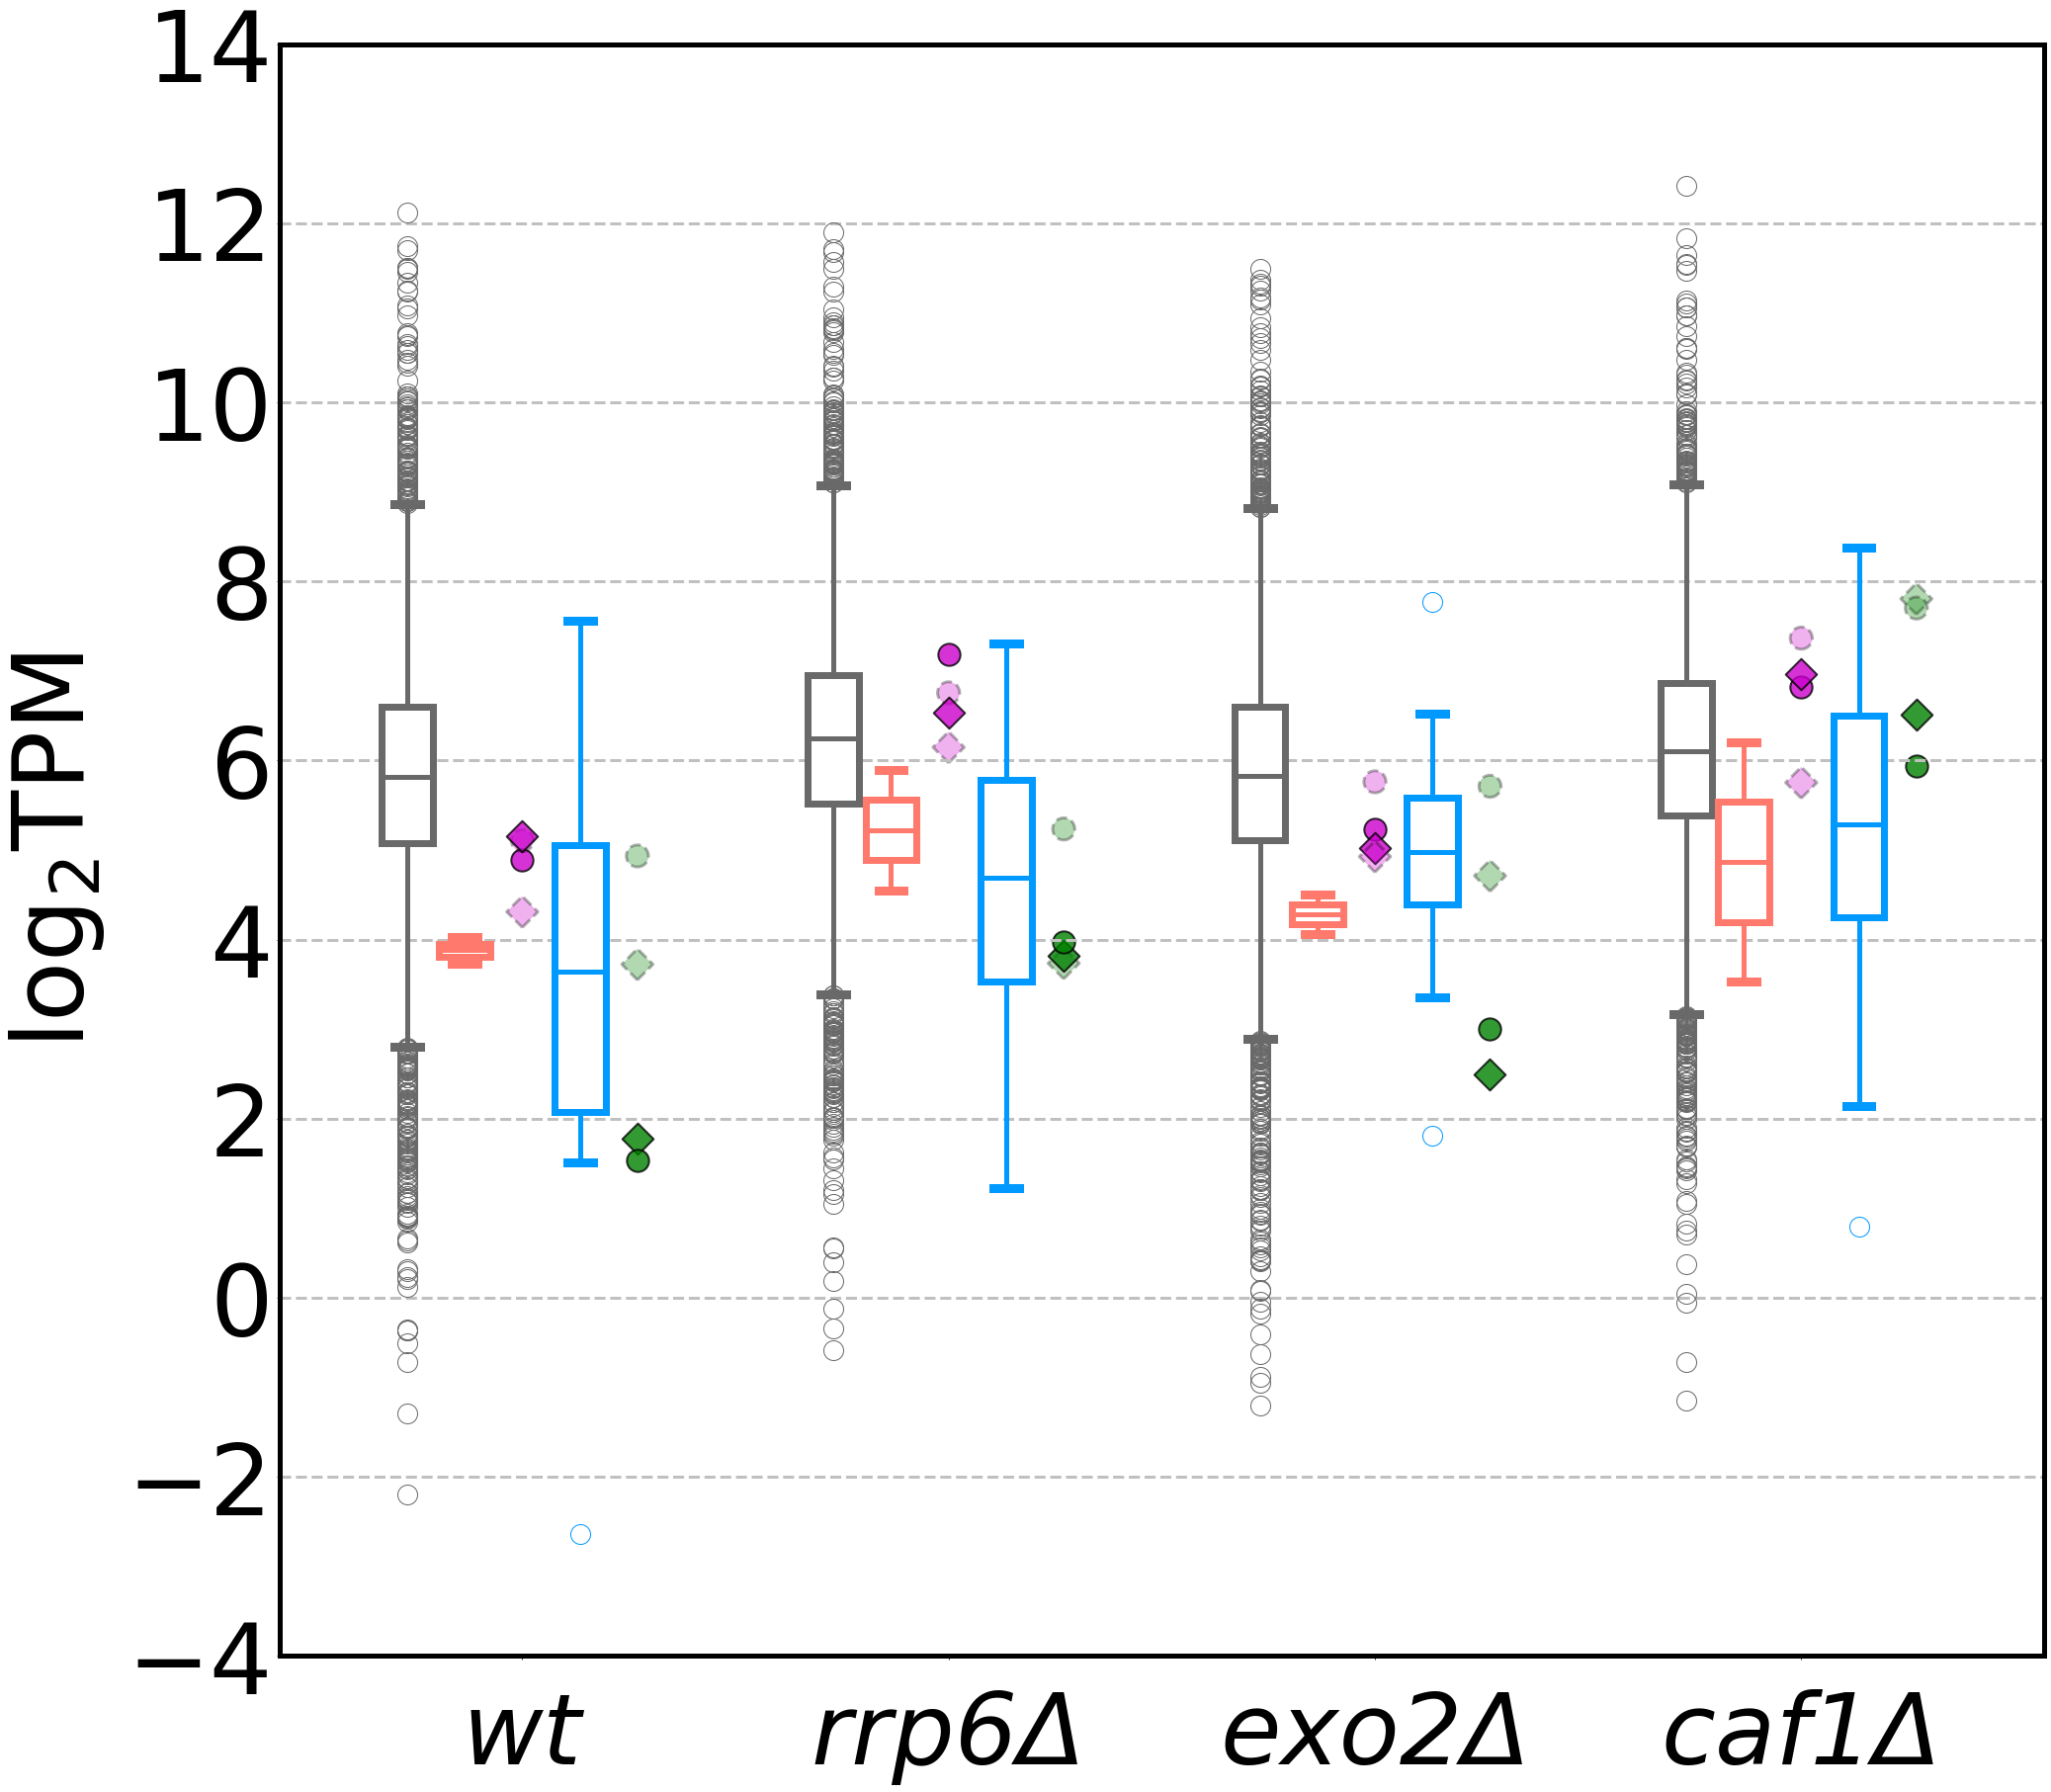

In [42]:
# data and labels
#samples = [i + '_S2-RIP' for i in samples2]
samples = [i + '_' + seq_assay for i in samples2]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-B.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-B.png')
out_path = os.path.join(fig_dir, 'Figure-S6-B.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                     
    x_labels2,
    out_path, 
    figsize=(32, 30),
    dist=5, 
    widths=.8,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14),
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

--------------------

## Mutant group 3 - <del>**Figure-S3-B-extra-ccr4-not-1**</del>  <font color='red'> **Figure-S6-B-extra-ccr4-not-1** </font>

- **Supplemental Figure S3**:  
    - **(A + B)** Box plot showing S2-Pol II RIP-seq data. Nascent RNA analysis is shown for individual mutants affecting 
    - **(B)** RNA degradation. Average of at least two independent samples is shown

In [43]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-B-extra-ccr4-not-1.png


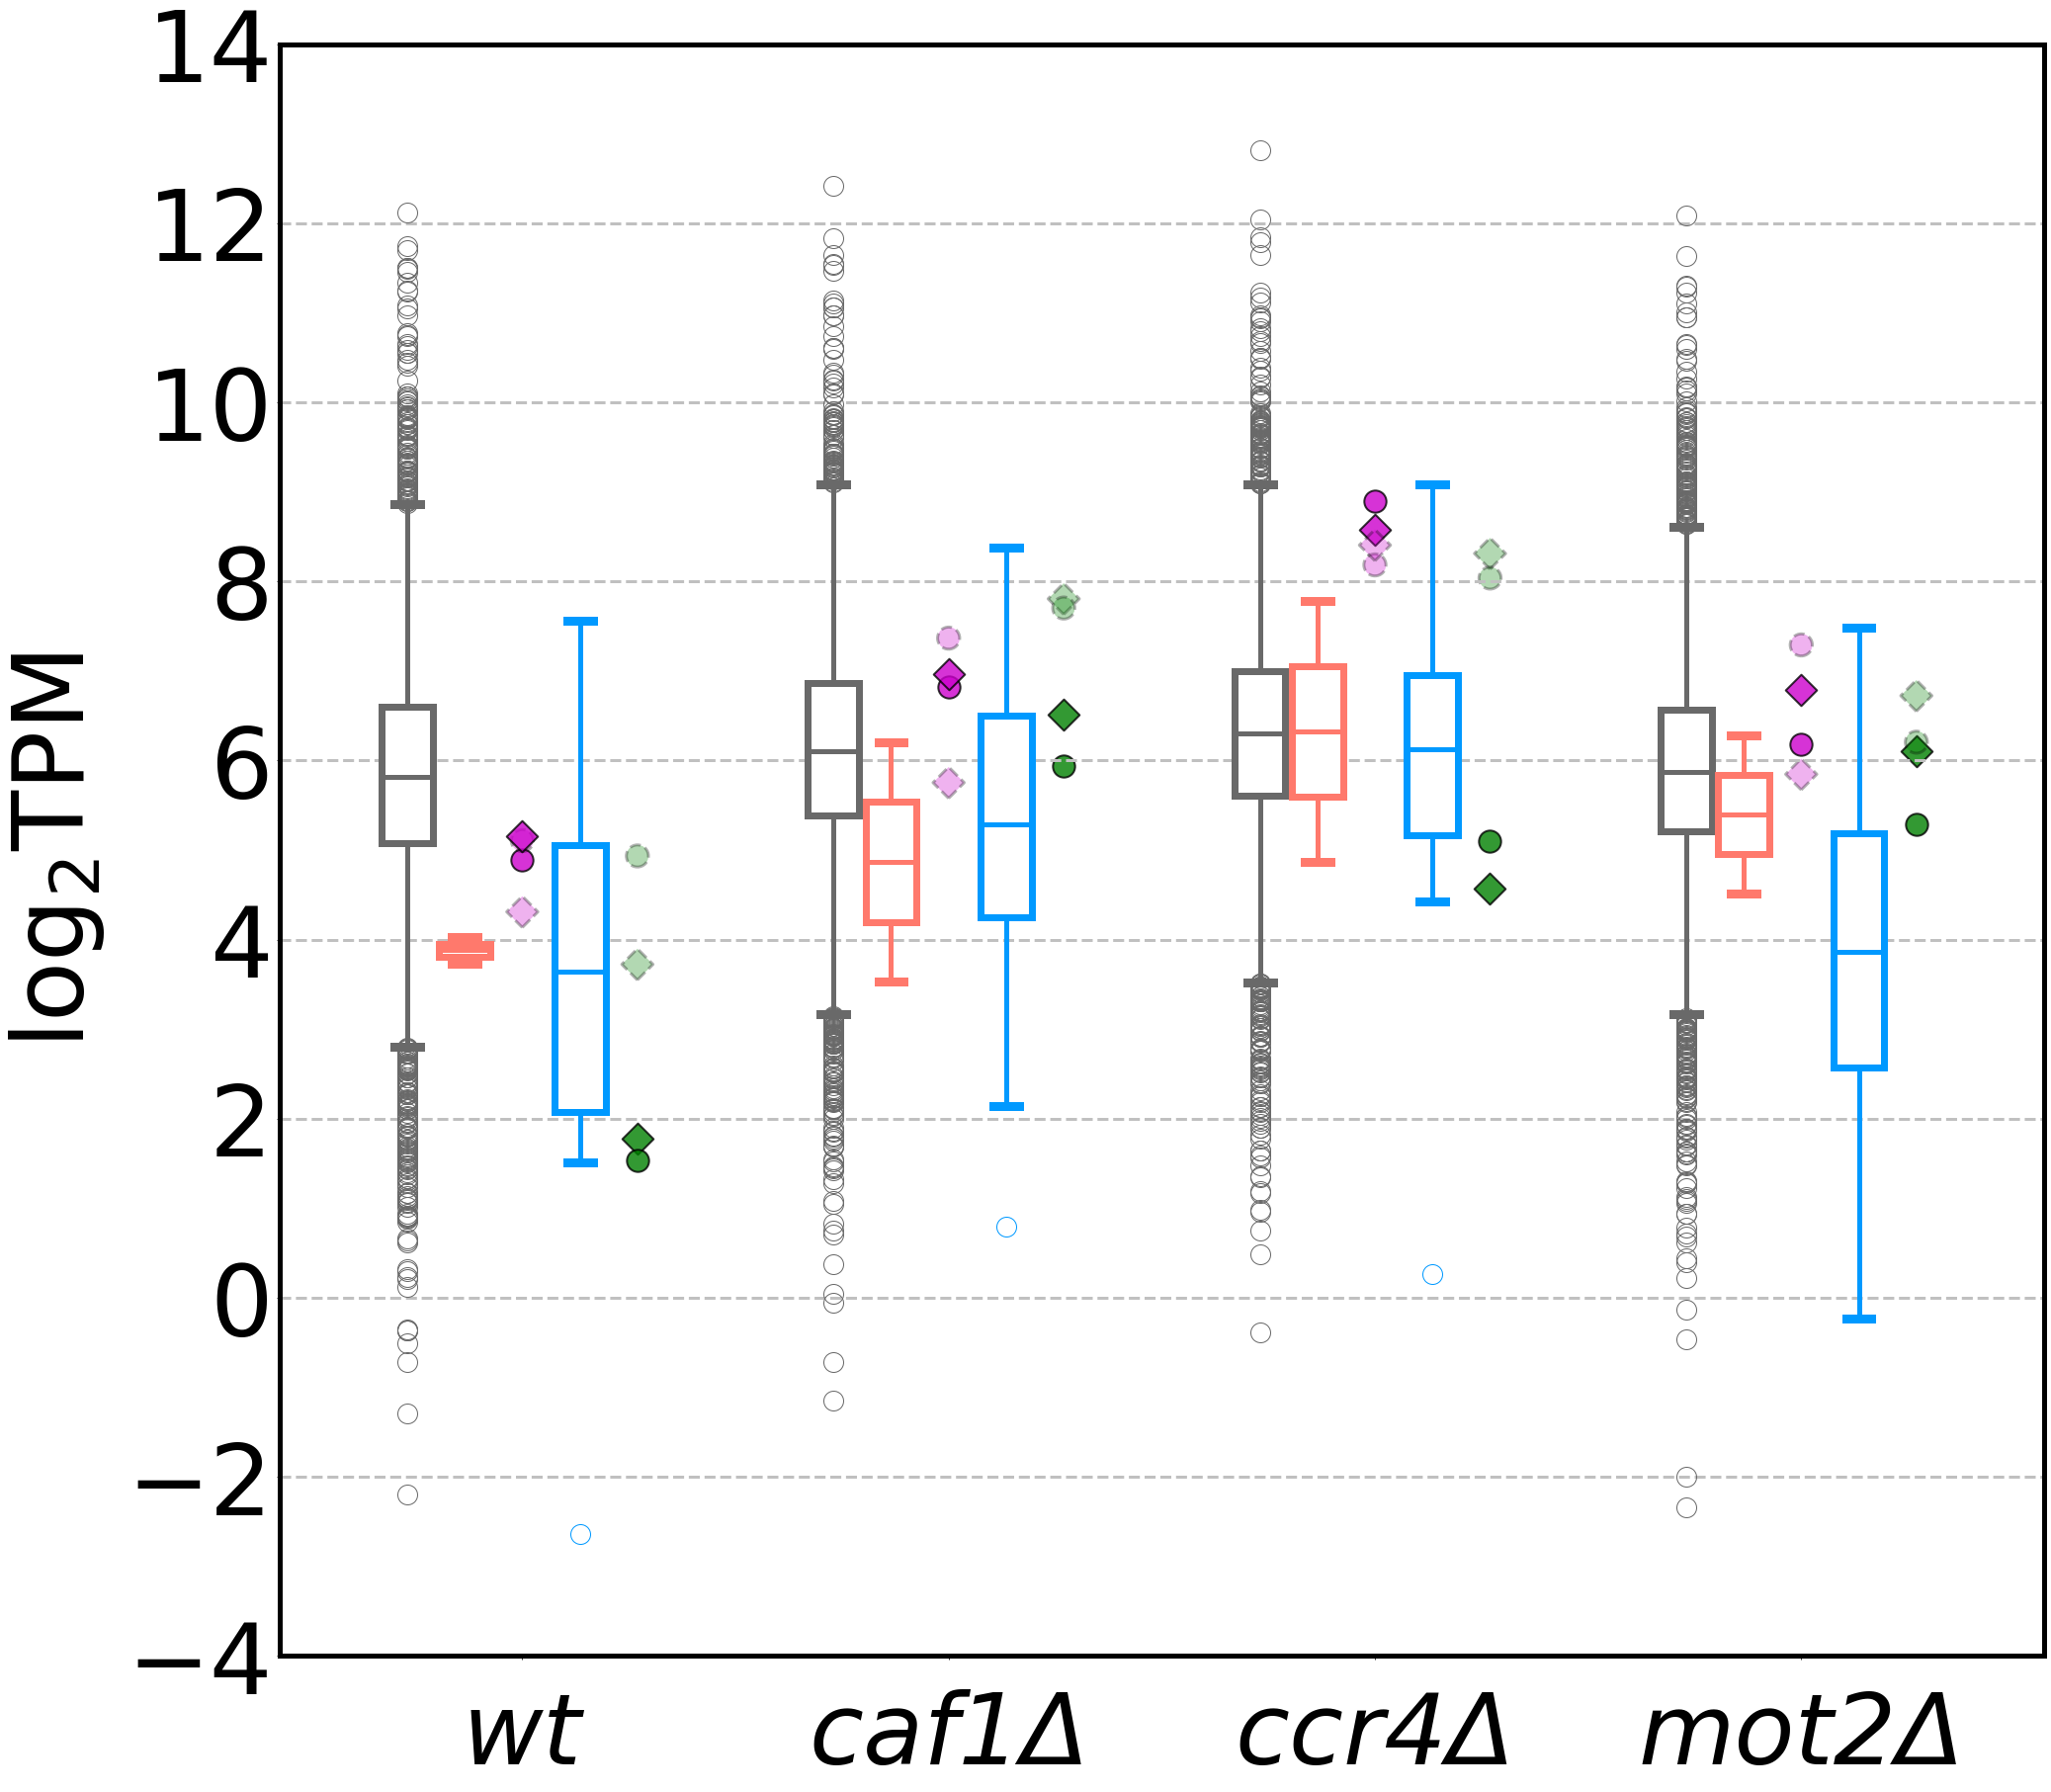

In [44]:
# data and labels
#samples = [i + '_S2-RIP' for i in samples3]
samples = [i + '_' + seq_assay for i in samples3]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-B-extra-ccr4-not-1.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-B-extra-ccr4-not-1.png')
out_path = os.path.join(fig_dir, 'Figure-S6-B-extra-ccr4-not-1.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                     
    x_labels3,
    out_path, 
    figsize=(32, 30),
    dist=5, 
    widths=.8,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14),
    xlable_size=100, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

--------------------

## Mutant group 4 - <del>**Figure-S3-B-extra-ccr4-not-2**</del>  <font color='red'> **Figure-S6-B-extra-ccr4-not-2** </font>

- **Supplemental Figure S3**:  
    - **(A + B)** Box plot showing S2-Pol II RIP-seq data. Nascent RNA analysis is shown for individual mutants affecting 
    - **(B)** RNA degradation. Average of at least two independent samples is shown

In [45]:
#fig_dir = os.path.join(plots_dir, 'Figure-S3')
fig_dir = os.path.join(plots_dir, 'Figure-S6')

if not os.path.isdir(fig_dir):    
    !mkdir -p $fig_dir

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_16-07-21/Figure-S6/Figure-S6-B-extra-ccr4-not-2.png


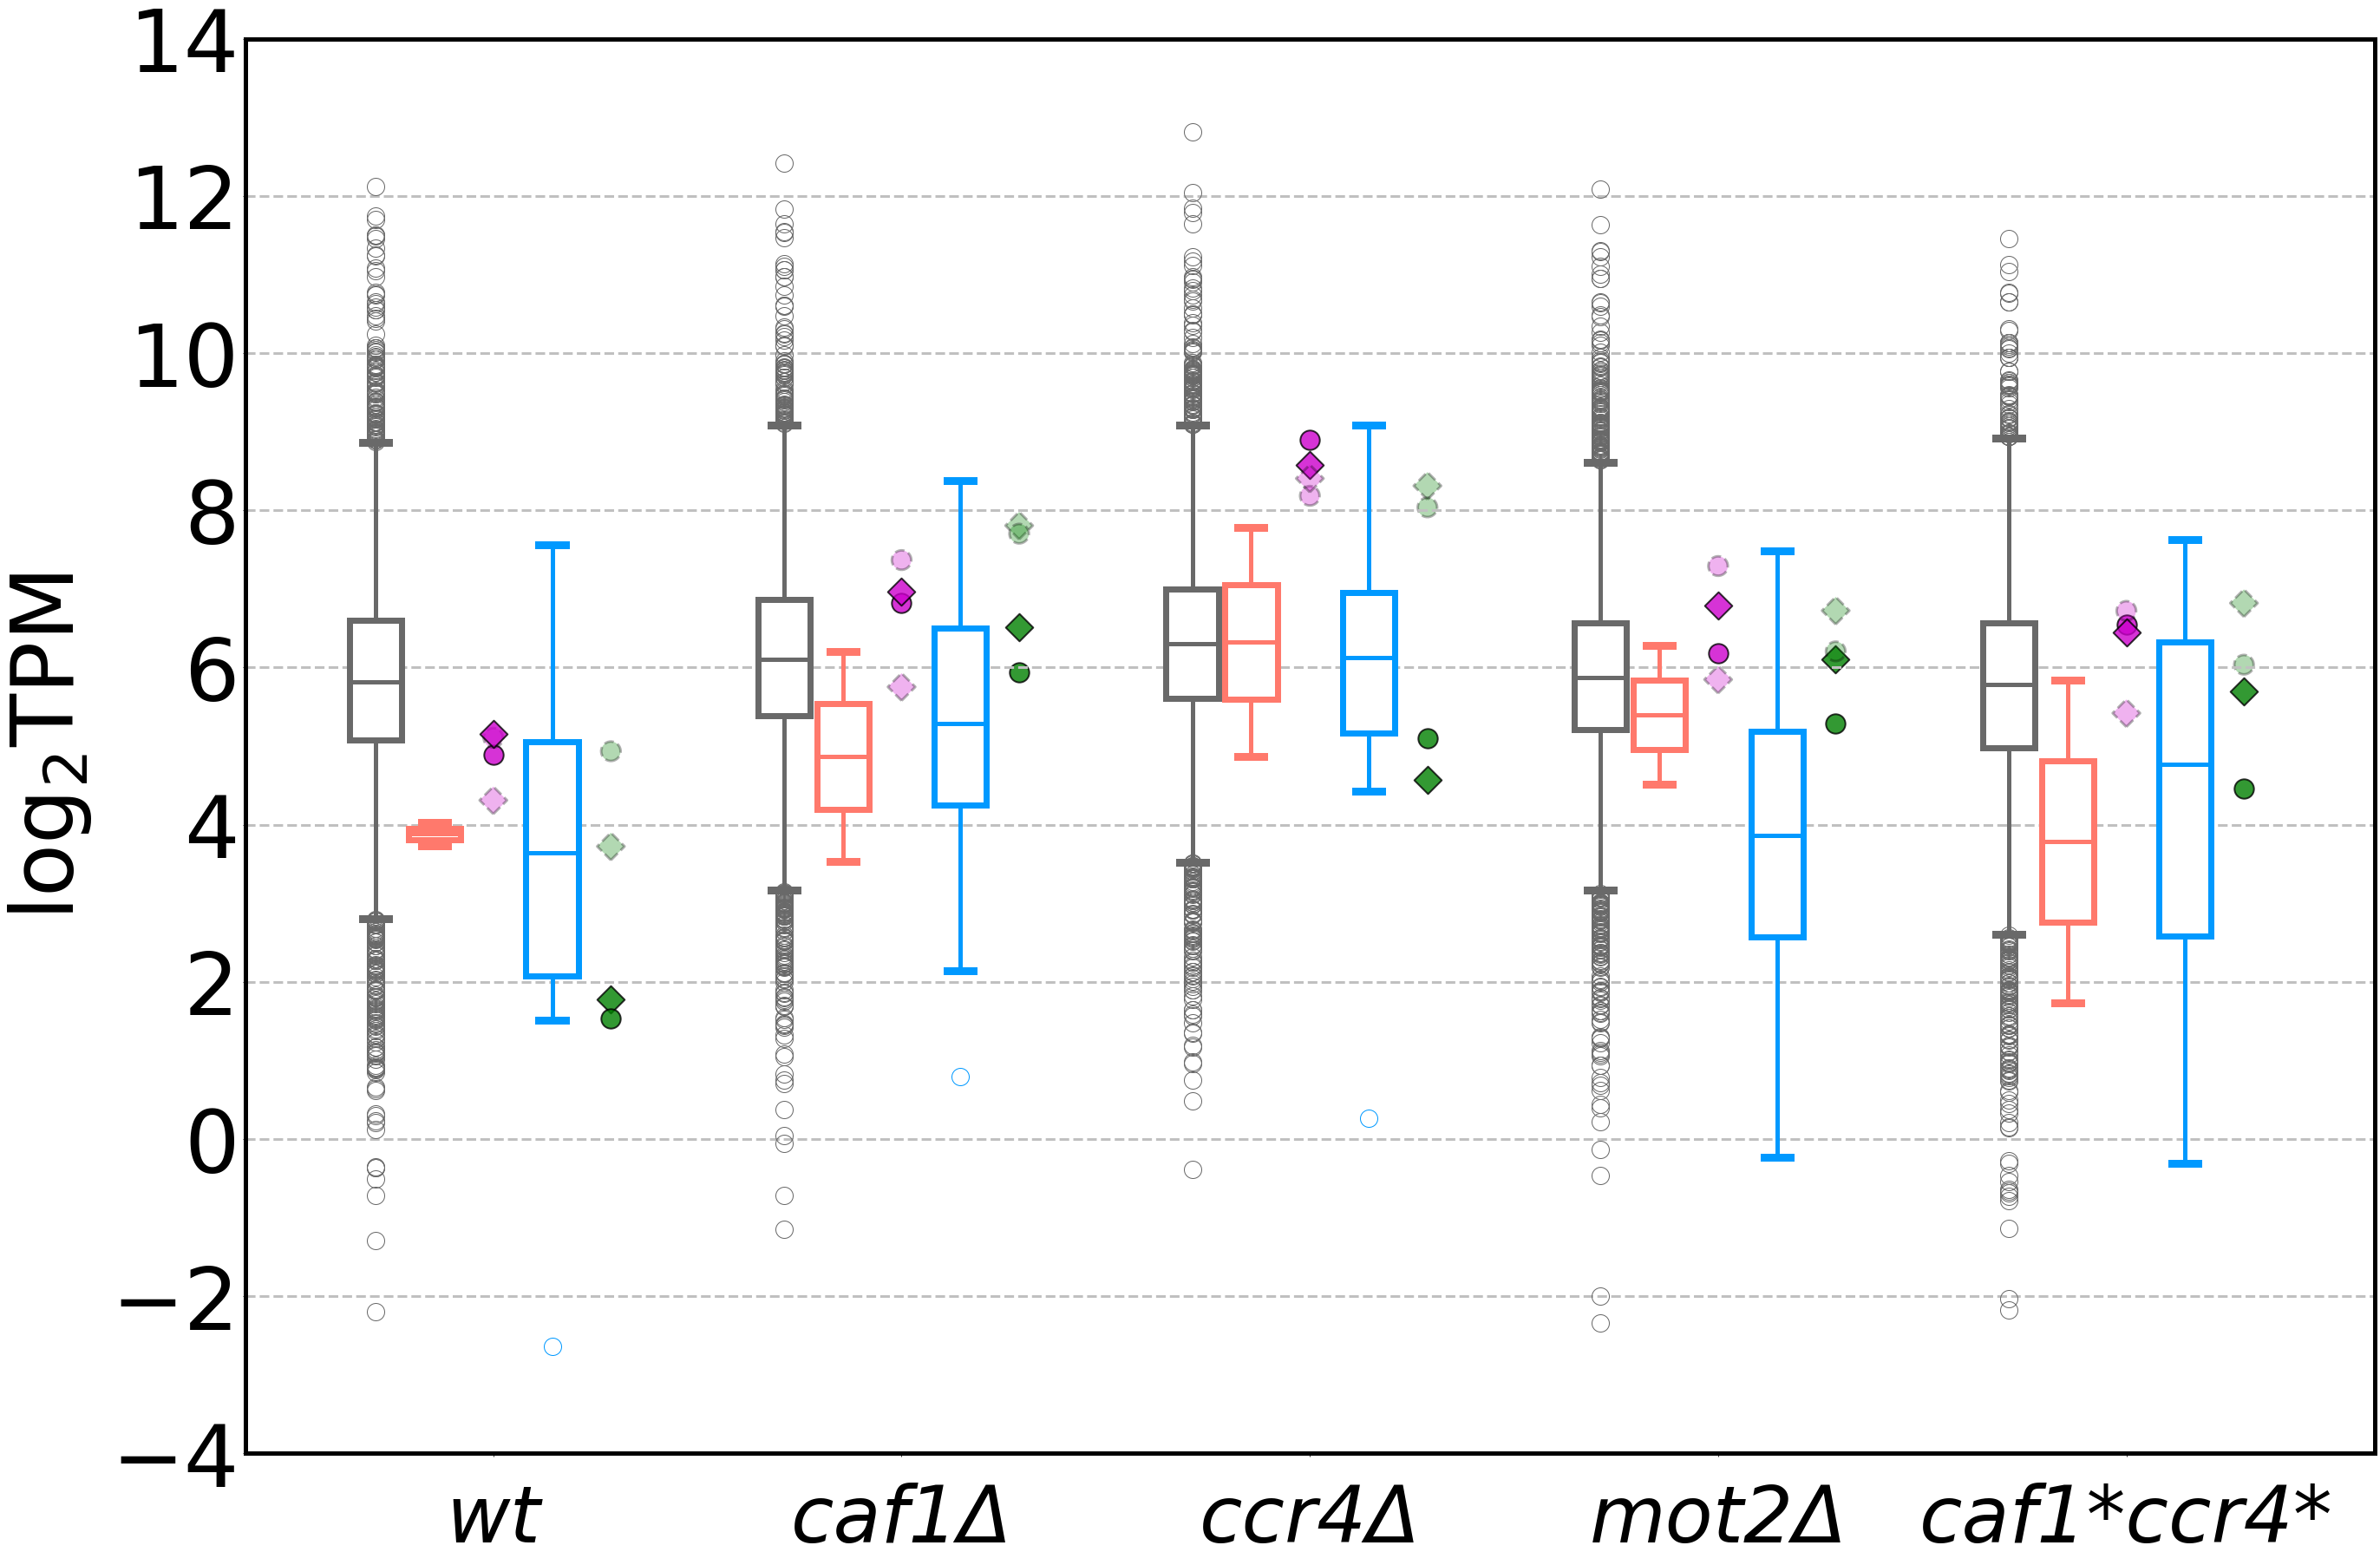

In [46]:
# data and labels
#samples = [i + '_S2-RIP' for i in samples4]
samples = [i + '_' + seq_assay for i in samples4]
#data = prepare_4cat_data(df, samples)

# path and plot
out_path = os.path.join(plots_dir, 'Figure-S3-B-extra-ccr4-not-2.png')
#out_path = os.path.join(fig_dir, 'Figure-S3-B-extra-ccr4-not-2.png')
out_path = os.path.join(fig_dir, 'Figure-S6-B-extra-ccr4-not-2.png')
print(out_path)

#multi_4cat_box_plot(data, samples,
my_multi_4cat_box_plot(
    df, samples,                     
    x_labels4,
    out_path, 
    figsize=(44, 30),
    dist=5, 
    widths=.8,
    y_label='$\mathrm{log_2TPM}$',
    y_lim=(-4, 14),
    xlable_size=90, ylable_size=100,
    annotate=annotate_plots,
    include_mat_locus_vis = include_mat_locus_vis
)

--------------------